# Snapping points to lines and identifying streets with the most street flooding complaints

Mark Bauer

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import contextily as ctx

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing verions of Python modules and packages with **watermark** - the IPython magic extension.

In [333]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [334]:
%watermark -v -p numpy,pandas,geopandas,matplotlib.pyplot,matplotlib,seaborn,fiona,contextily

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
geopandas 0.8.1
matplotlib.pyplot 3.3.2
matplotlib 3.3.2
seaborn 0.11.1
fiona 1.8.13.post1
contextily 1.0.0


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [335]:
# list items in data folder
%ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [336]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw-street-flooding-data.csv')

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27868, 38)


/Users/geribauer/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


unique_key             created_date              closed_date agency  \
0    31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
1    25163797  2013-03-12T12:38:00.000  2013-03-12T14:20:00.000    DEP   
2    25185984  2013-03-15T12:13:00.000  2013-03-18T14:15:00.000    DEP   
3    25187738  2013-03-15T12:20:00.000  2013-03-15T14:22:00.000    DEP   
4    25338491  2013-04-11T12:16:00.000  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip  incident_address       street_name  \
0  Street Flooding (SJ)       11694.0  BEACH 101 STREET  BEACH 101 STREET   
1  Street Flooding (SJ)       11236.0       CHURCH LANE       CHURCH LANE   
2  Street Flooding (SJ)       11236.0       CHURCH LANE       CHURCH LANE   
3  Street Flooding (SJ)       11236.0       CHURCH LANE       CHURCH LANE   
4  Street Flooding (SJ)       11236.0       CHURCH LANE       CHURCH LANE   

   ... intersection_street_1 intersection_street_2 bbl location_type  \
0  ...                   NaN                   NaN NaN           NaN   
1  ...                   NaN                   NaN NaN           NaN   
2  ...                   NaN                   NaN NaN           NaN   
3  ...                   NaN                   NaN NaN           NaN   
4  ...                   NaN                   NaN NaN           NaN   

   due_date landmark bridge_highway_name bridge_highway_direction road_ramp  \
0       NaN      NaN                 NaN                      NaN       NaN   
1       NaN      NaN                 NaN                      NaN       NaN   
2       NaN      NaN                 NaN                      NaN       NaN   
3       NaN      NaN                 NaN                      NaN       NaN   
4       NaN      NaN                 NaN                      NaN       NaN   

  bridge_highway_segment  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 38 columns]

In [337]:
# previewing the last five rows of our dataframe
flooding_311.tail()

unique_key             created_date              closed_date agency  \
27863    31087754  2015-07-15T11:54:00.000  2015-07-15T13:45:00.000    DEP   
27864    23268850  2012-05-21T15:13:00.000  2012-05-25T14:30:00.000    DEP   
27865    23298517  2012-05-25T22:41:00.000  2012-05-29T17:50:00.000    DEP   
27866    31195478  2015-07-30T18:05:00.000  2015-07-30T18:05:00.000    DEP   
27867    31504023  2015-09-10T08:45:00.000  2015-09-10T13:11:00.000    DEP   

                                  agency_name complaint_type  \
27863  Department of Environmental Protection          Sewer   
27864  Department of Environmental Protection          Sewer   
27865  Department of Environmental Protection          Sewer   
27866  Department of Environmental Protection          Sewer   
27867  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip     incident_address    street_name  \
27863  Street Flooding (SJ)       11225.0      99 OCEAN AVENUE   OCEAN AVENUE   
27864  Street Flooding (SJ)       10016.0                  NaN            NaN   
27865  Street Flooding (SJ)       10454.0                  NaN            NaN   
27866  Street Flooding (SJ)       11433.0                  NaN            NaN   
27867  Street Flooding (SJ)       11691.0  10-95 GIPSON STREET  GIPSON STREET   

       ...   intersection_street_1 intersection_street_2           bbl  \
27863  ...                     NaN                   NaN  3.050240e+09   
27864  ...                 E 28 ST                 1 AVE           NaN   
27865  ...              WILLIS AVE              E 134 ST           NaN   
27866  ...  GUY R BREWER BOULEVARD            109 AVENUE           NaN   
27867  ...                     NaN                   NaN  4.157170e+09   

      location_type  due_date landmark bridge_highway_name  \
27863           NaN       NaN      NaN                 NaN   
27864           NaN       NaN      NaN                 NaN   
27865           NaN       NaN      NaN                 NaN   
27866           NaN       NaN      NaN                 NaN   
27867           NaN       NaN      NaN                 NaN   

      bridge_highway_direction road_ramp bridge_highway_segment  
27863                      NaN       NaN                    NaN  
27864                      NaN       NaN                    NaN  
27865                      NaN       NaN                    NaN  
27866                      NaN       NaN                    NaN  
27867                      NaN       NaN                    NaN  

[5 rows x 38 columns]

# 3. Data Inspection

In [338]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [339]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'bbl', 'location_type', 'due_date', 'landmark',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment'],
      dtype='object')

In [340]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
incident_address                   object
street_name                        object
cross_street_1                     object
cross_street_2                     object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type             object
park_facility_name                

In [341]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27868 non-null  int64  
 1   created_date                    27868 non-null  object 
 2   closed_date                     27866 non-null  object 
 3   agency                          27868 non-null  object 
 4   agency_name                     27868 non-null  object 
 5   complaint_type                  27868 non-null  object 
 6   descriptor                      27868 non-null  object 
 7   incident_zip                    27011 non-null  float64
 8   incident_address                17835 non-null  object 
 9   street_name                     17835 non-null  object 
 10  cross_street_1                  24114 non-null  object 
 11  cross_street_2                  24103 non-null  object 
 12  address_type                    

In [342]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'facility_type', 'status', 'resolution_description',
       'resolution_action_updated_date', 'community_board', 'borough',
       'x_coordinate_state_plane', 'y_coordinate_state_plane',
       'open_data_channel_type', 'park_facility_name', 'park_borough',
       'latitude', 'longitude', 'location', 'intersection_street_1',
       'intersection_street_2', 'bbl', 'location_type', 'due_date', 'landmark',
       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
       'bridge_highway_segment'],
      dtype='object')

In [343]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [344]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27868 entries, 0 to 27867
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27868 non-null  int64  
 1   created_date                    27868 non-null  object 
 2   closed_date                     27866 non-null  object 
 3   agency                          27868 non-null  object 
 4   agency_name                     27868 non-null  object 
 5   complaint_type                  27868 non-null  object 
 6   descriptor                      27868 non-null  object 
 7   incident_zip                    27011 non-null  float64
 8   intersection_street_1           10090 non-null  object 
 9   intersection_street_2           10090 non-null  object 
 10  address_type                    27862 non-null  object 
 11  city                            27012 non-null  object 
 12  status                          

In [345]:
# counts of unique values of our datatypes 
flooding_311.dtypes.value_counts()

object     23
float64     6
int64       1
dtype: int64

In [346]:
# printing index type
flooding_311.index

RangeIndex(start=0, stop=27868, step=1)

In [347]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [348]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27868
Name: descriptor, dtype: int64

In [349]:
flooding_311.shape

(27868, 30)

In [350]:
flooding_311.x_coordinate_state_plane.isna().sum()

943

In [351]:
# You may want to drop any that didn't snap, if so:
flooding_311 = flooding_311.dropna(subset=["x_coordinate_state_plane"])

In [352]:
flooding_311.x_coordinate_state_plane.isna().sum()

0

In [353]:
flooding_311.shape

(26925, 30)

In [354]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [355]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26925 entries, 0 to 27867
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26925 non-null  float64
 1   y_coordinate_state_plane  26925 non-null  float64
dtypes: float64(2)
memory usage: 631.1 KB


In [356]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

nta_shape.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  
1         4  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  
2         4  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  
3         3  MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...  
4         4  MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...

In [357]:
nta_shape.to_crs(epsg=2263, inplace=True)
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

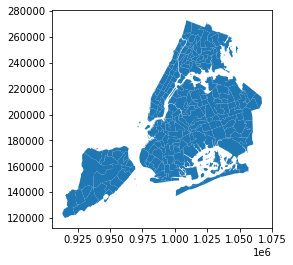

In [358]:
nta_shape.plot()

In [359]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


# 4. Mapping

## City-Wide

In [360]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [361]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [362]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ...           bbl                        geometry  \
0                     NaN  ...           NaN  POINT (1033547.000 152391.000)   
352                   NaN  ...  4.163140e+09  POINT (1021913.000 146937.000)   
379                   NaN  ...  4.162250e+09  POINT (1026335.000 149464.000)   
424                   NaN  ...  4.161660e+09  POINT (1029969.000 151595.000)   
698                   NaN  ...  4.162380e+09  POINT (1026572.000 148945.000)   

    index_right ntacode     shape_area county_fips  \
0           182    QN10  100209724.039         081   
352         182    QN10  100209724.039         081   
379         182    QN10  100209724.039         081   
424         182    QN10  100209724.039         081   
698         182    QN10  100209724.039         081   

                                               ntaname     shape_leng  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   

     boro_name boro_code  
0       Queens         4  
352     Queens         4  
379     Queens         4  
424     Queens         4  
698     Queens         4  

[5 rows x 39 columns]

<AxesSubplot:>

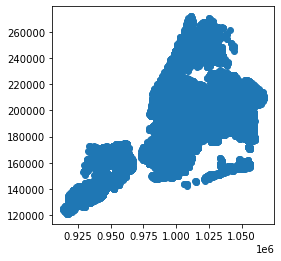

In [363]:
gdf.plot()

In [364]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26923 entries, 0 to 12747
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26923 non-null  int64   
 1   created_date                    26923 non-null  object  
 2   closed_date                     26921 non-null  object  
 3   agency                          26923 non-null  object  
 4   agency_name                     26923 non-null  object  
 5   complaint_type                  26923 non-null  object  
 6   descriptor                      26923 non-null  object  
 7   incident_zip                    26923 non-null  float64 
 8   intersection_street_1           9346 non-null   object  
 9   intersection_street_2           9346 non-null   object  
 10  address_type                    26923 non-null  object  
 11  city                            26923 non-null  object  
 12  status    

In [365]:
gdf.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count  2.692300e+04  26923.000000              2.692300e+04   
mean   3.252830e+07  10969.498236              1.005499e+06   
std    9.160705e+06    536.366773              3.504831e+04   
min    1.563993e+07  10001.000000              9.133570e+05   
25%    2.450803e+07  10312.000000              9.868830e+05   
50%    3.286467e+07  11221.000000              1.007480e+06   
75%    4.040870e+07  11385.000000              1.033986e+06   
max    4.854313e+07  11697.000000              1.067279e+06   

       y_coordinate_state_plane      latitude     longitude           bbl  \
count              26923.000000  24424.000000  24424.000000  1.613300e+04   
mean              186171.663336     40.677470    -73.922107  3.699597e+09   
std                30566.041327      0.083676      0.126311  1.075714e+09   
min               121032.000000     40.498628    -74.254937  0.000000e+00   
25%               161248.000000     40.609110    -73.989723  3.060320e+09   
50%               183608.000000     40.670461    -73.915316  4.067910e+09   
75%               206470.000000     40.732345    -73.819514  4.156250e+09   
max               271876.000000     40.912869    -73.700384  5.080500e+09   

        index_right  
count  26923.000000  
mean     100.090072  
std       58.709685  
min        0.000000  
25%       50.000000  
50%       97.000000  
75%      159.000000  
max      194.000000

In [366]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [367]:
ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [368]:
path = 'data-raw/raw-streets-clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [369]:
streets.shape

(99362, 12)

<AxesSubplot:>

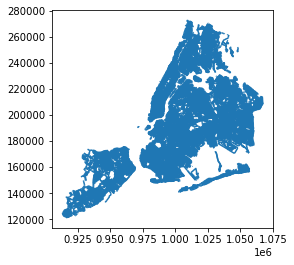

In [370]:
streets.plot()

In [371]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [372]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [373]:
streets.describe()

shape_leng
count  9.936200e+04
mean   3.431188e+02
std    2.620211e+02
min    1.068681e-08
25%    1.953735e+02
50%    2.648459e+02
75%    4.583545e+02
max    1.509366e+04

# Snap points to lines

In [374]:
streets.sindex

rtree.index.Index(bounds=[913351.9846191381, 120918.59619133211, 1067379.5294189155, 272688.0944213113], size=99362)

In [375]:
offset = 80

bbox = gdf.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny       maxx      maxy
0    1033467.0  152311.0  1033627.0  152471.0
352  1021833.0  146857.0  1021993.0  147017.0
379  1026255.0  149384.0  1026415.0  149544.0
424  1029889.0  151515.0  1030049.0  151675.0
698  1026492.0  148865.0  1026652.0  149025.0

In [376]:
hits = bbox.apply(lambda row: list(streets.sindex.intersection(row)), axis=1)

hits.head()

0      [66771, 53285, 72937, 50599, 22955, 27601]
352                                       [97447]
379                                       [54349]
424                                [82258, 14459]
698                                 [49846, 9255]
dtype: object

In [377]:
hits.shape

(26923,)

In [378]:
tmp = pd.DataFrame(
                {
                # index of points table
                "pt_idx": np.repeat(hits.index, hits.apply(len)),
                    
                # ordinal position of line - access via iloc later
                "line_i": np.concatenate(hits.values)
                })

In [379]:
tmp.head()

pt_idx   line_i
0       0  66771.0
1       0  53285.0
2       0  72937.0
3       0  50599.0
4       0  22955.0

In [380]:
tmp.shape

(89669, 2)

In [381]:
streets.shape

(99362, 12)

In [382]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [383]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx   line_i physicalid      st_label   st_name    full_stree rw_type  \
0       0  66771.0      14944  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
1       0  53285.0      14743    BCH 101 ST       101    BCH 101 ST       1   
2       0  72937.0     117130    BCH 100 ST     B 100      B 100 ST       1   
3       0  50599.0      14740    BCH 101 ST       101    BCH 101 ST       1   
4       0  22955.0      14945  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       50         13        13        4  258.194986   
1       Street       30         13        13        4   69.425460   
2       Street       20         13        13        4  462.903399   
3       Street       30         13        13        4  438.370979   
4       Street       50         13        13        4  200.031040   

                                            geometry  
0  LINESTRING (1033578.079 152329.868, 1033338.22...  
1  LINESTRING (1033517.226 152453.480, 1033487.01...  
2  LINESTRING (1033756.693 152419.920, 1033698.08...  
3  LINESTRING (1033767.314 151934.445, 1033715.52...  
4  LINESTRING (1033756.693 152419.920, 1033578.07...

In [384]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(gdf.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=gdf.crs)

In [385]:
tmp.head()

pt_idx   line_i physicalid      st_label   st_name    full_stree rw_type  \
0       0  66771.0      14944  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
1       0  53285.0      14743    BCH 101 ST       101    BCH 101 ST       1   
2       0  72937.0     117130    BCH 100 ST     B 100      B 100 ST       1   
3       0  50599.0      14740    BCH 101 ST       101    BCH 101 ST       1   
4       0  22955.0      14945  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       50         13        13        4  258.194986   
1       Street       30         13        13        4   69.425460   
2       Street       20         13        13        4  462.903399   
3       Street       30         13        13        4  438.370979   
4       Street       50         13        13        4  200.031040   

                                            geometry  \
0  LINESTRING (1033578.079 152329.868, 1033338.22...   
1  LINESTRING (1033517.226 152453.480, 1033487.01...   
2  LINESTRING (1033756.693 152419.920, 1033698.08...   
3  LINESTRING (1033767.314 151934.445, 1033715.52...   
4  LINESTRING (1033756.693 152419.920, 1033578.07...   

                            point  
0  POINT (1033547.000 152391.000)  
1  POINT (1033547.000 152391.000)  
2  POINT (1033547.000 152391.000)  
3  POINT (1033547.000 152391.000)  
4  POINT (1033547.000 152391.000)

In [386]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp.head()

pt_idx   line_i physicalid      st_label   st_name    full_stree rw_type  \
0       0  66771.0      14944  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
1       0  53285.0      14743    BCH 101 ST       101    BCH 101 ST       1   
2       0  72937.0     117130    BCH 100 ST     B 100      B 100 ST       1   
3       0  50599.0      14740    BCH 101 ST       101    BCH 101 ST       1   
4       0  22955.0      14945  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       50         13        13        4  258.194986   
1       Street       30         13        13        4   69.425460   
2       Street       20         13        13        4  462.903399   
3       Street       30         13        13        4  438.370979   
4       Street       50         13        13        4  200.031040   

                                            geometry  \
0  LINESTRING (1033578.079 152329.868, 1033338.22...   
1  LINESTRING (1033517.226 152453.480, 1033487.01...   
2  LINESTRING (1033756.693 152419.920, 1033698.08...   
3  LINESTRING (1033767.314 151934.445, 1033715.52...   
4  LINESTRING (1033756.693 152419.920, 1033578.07...   

                            point   snap_dist  
0  POINT (1033547.000 152391.000)   68.294263  
1  POINT (1033547.000 152391.000)   69.211382  
2  POINT (1033547.000 152391.000)  201.649491  
3  POINT (1033547.000 152391.000)   68.578808  
4  POINT (1033547.000 152391.000)   68.578808

In [387]:
tmp[['snap_dist']].describe()

snap_dist
count  89669.000000
mean      48.762701
std      109.139465
min        0.000002
25%        0.429117
50%        3.354707
75%       63.698623
max     3109.136264

In [388]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx   line_i physicalid st_label st_name  full_stree rw_type  \
47962   22502  78871.0      53191    63 ST      63       63 ST       1   
57791    7243  75852.0      12940    99 ST      99       99 ST       1   
57815    8898  75852.0      12940    99 ST      99       99 ST       1   
48883   20816  17714.0      45636  E 22 ST      22    E  22 ST       1   
32012   13254  33502.0       1116    8 AVE  EIGHTH  EIGHTH AVE       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
47962       Street       30         13        13        3  778.787201   
57791       Street       56         13        13        4  776.951894   
57815       Street       56         13        13        4  776.951894   
48883       Street       30         13        13        3  880.043541   
32012       Street       68         13        13        1  261.957251   

                                                geometry  \
47962  LINESTRING (984162.923 167762.061, 984772.939 ...   
57791  LINESTRING (1022531.087 209487.727, 1022844.15...   
57815  LINESTRING (1022531.087 209487.727, 1022844.15...   
48883  LINESTRING (996772.973 168199.186, 996898.570 ...   
32012  LINESTRING (984801.902 211046.822, 984928.407 ...   

                                point  snap_dist  
47962   POINT (984163.000 167762.000)   0.000002  
57791  POINT (1022844.000 208777.000)   0.000026  
57815  POINT (1022844.000 208777.000)   0.000026  
48883   POINT (996773.000 168199.000)   0.000030  
32012   POINT (984802.000 211047.000)   0.000045

In [389]:
tmp[['snap_dist']].describe()

snap_dist
count  73247.000000
mean      16.297119
std       23.967525
min        0.000002
25%        0.358298
50%        2.784413
75%       29.628665
max       79.994171

In [390]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid    st_label st_name  full_stree rw_type  \
pt_idx                                                               
0       27601.0      14742  BCH 101 ST     101  BCH 101 ST       1   
1       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
2       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
3       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
4       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       30         13        13        4  137.778871   
1            Street       20         13        13        3  261.929557   
2            Street       20         13        13        3  261.929557   
3            Street       20         13        13        3  261.929557   
4            Street       20         13        13        3  261.929557   

                                                 geometry  \
pt_idx                                                      
0       LINESTRING (1033578.079 152329.868, 1033517.22...   
1       LINESTRING (1010780.720 171600.495, 1010590.98...   
2       LINESTRING (1010780.720 171600.495, 1010590.98...   
3       LINESTRING (1010780.720 171600.495, 1010590.98...   
4       LINESTRING (1010780.720 171600.495, 1010590.98...   

                                 point  snap_dist  
pt_idx                                             
0       POINT (1033547.000 152391.000)   0.883029  
1       POINT (1010685.000 171510.000)   0.436756  
2       POINT (1010685.000 171510.000)   0.436756  
3       POINT (1010685.000 171510.000)   0.436756  
4       POINT (1010685.000 171510.000)   0.436756

In [391]:
closest.index.is_unique

True

In [392]:
closest.physicalid.is_unique

False

In [393]:
len(gdf)

26923

In [394]:
len(closest)

26863

In [395]:
len(closest)/len(gdf)

0.9977714222040635

In [396]:
print("We've dropped", str(len(gdf) - len(closest)), '(' + \
      str(round((1 - (len(closest) / len(gdf))) * 100, 2)) + \
      '%) of street flooding complaint points that\nwere more than 80 ft. ' + \
      'from the closest street center line.')

We've dropped 60 (0.22%) of street flooding complaint points that
were more than 80 ft. from the closest street center line.


In [397]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
0    POINT (1033547.792 152391.390)
1    POINT (1010685.301 171509.684)
2    POINT (1010685.301 171509.684)
3    POINT (1010685.301 171509.684)
4    POINT (1010685.301 171509.684)
dtype: geometry

In [398]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid    st_label st_name  full_stree rw_type  \
pt_idx                                                               
0       27601.0      14742  BCH 101 ST     101  BCH 101 ST       1   
1       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
2       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
3       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
4       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       30         13        13        4  137.778871   
1            Street       20         13        13        3  261.929557   
2            Street       20         13        13        3  261.929557   
3            Street       20         13        13        3  261.929557   
4            Street       20         13        13        3  261.929557   

                              geometry                           point  \
pt_idx                                                                   
0       POINT (1033547.792 152391.390)  POINT (1033547.000 152391.000)   
1       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   
2       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   
3       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   
4       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   

        snap_dist  
pt_idx             
0        0.883029  
1        0.436756  
2        0.436756  
3        0.436756  
4        0.436756

In [399]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ...       cross_street_1       cross_street_2  \
0                     NaN  ...     ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE   
352                   NaN  ...  ROCKAWAY BEACH BLVD         NEPONSIT AVE   
379                   NaN  ...  ROCKAWAY BEACH BLVD          NEWPORT AVE   
424                   NaN  ...        ROCKAWAY FRWY                 BEND   
698                   NaN  ...           OCEAN PROM  ROCKAWAY BEACH BLVD   

              bbl                        geometry index_right ntacode  \
0             NaN  POINT (1033547.000 152391.000)         182    QN10   
352  4.163140e+09  POINT (1021913.000 146937.000)         182    QN10   
379  4.162250e+09  POINT (1026335.000 149464.000)         182    QN10   
424  4.161660e+09  POINT (1029969.000 151595.000)         182    QN10   
698  4.162380e+09  POINT (1026572.000 148945.000)         182    QN10   

    county_fips                                            ntaname  boro_name  \
0           081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens   
352         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens   
379         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens   
424         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens   
698         081  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens   

    boro_code  
0           4  
352         4  
379         4  
424         4  
698         4  

[5 rows x 37 columns]

In [400]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26923 entries, 0 to 12747
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      26923 non-null  int64   
 1   created_date                    26923 non-null  object  
 2   closed_date                     26921 non-null  object  
 3   agency                          26923 non-null  object  
 4   agency_name                     26923 non-null  object  
 5   complaint_type                  26923 non-null  object  
 6   descriptor                      26923 non-null  object  
 7   incident_zip                    26923 non-null  float64 
 8   intersection_street_1           9346 non-null   object  
 9   intersection_street_2           9346 non-null   object  
 10  address_type                    26923 non-null  object  
 11  city                            26923 non-null  object  
 12  status    

In [401]:
gdf.drop(columns=["geometry"], inplace=True)

In [402]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ...          street_name       cross_street_1  \
0                     NaN  ...     BEACH 101 STREET     ROCKAWAY FREEWAY   
352                   NaN  ...    BEACH  149 STREET  ROCKAWAY BEACH BLVD   
379                   NaN  ...    BEACH  129 STREET  ROCKAWAY BEACH BLVD   
424                   NaN  ...  BEACH CHANNEL DRIVE        ROCKAWAY FRWY   
698                   NaN  ...    BEACH  129 STREET           OCEAN PROM   

          cross_street_2           bbl index_right ntacode county_fips  \
0    BEACH CHANNEL DRIVE           NaN         182    QN10         081   
352         NEPONSIT AVE  4.163140e+09         182    QN10         081   
379          NEWPORT AVE  4.162250e+09         182    QN10         081   
424                 BEND  4.161660e+09         182    QN10         081   
698  ROCKAWAY BEACH BLVD  4.162380e+09         182    QN10         081   

                                               ntaname  boro_name boro_code  
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens         4  
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens         4  
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens         4  
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens         4  
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...     Queens         4  

[5 rows x 36 columns]

In [403]:
snapped.head()

line_i physicalid    st_label st_name  full_stree rw_type  \
pt_idx                                                               
0       27601.0      14742  BCH 101 ST     101  BCH 101 ST       1   
1       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
2       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
3       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   
4       61073.0      90215   CHURCH LN  CHURCH   CHURCH LN       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
0            Street       30         13        13        4  137.778871   
1            Street       20         13        13        3  261.929557   
2            Street       20         13        13        3  261.929557   
3            Street       20         13        13        3  261.929557   
4            Street       20         13        13        3  261.929557   

                              geometry                           point  \
pt_idx                                                                   
0       POINT (1033547.792 152391.390)  POINT (1033547.000 152391.000)   
1       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   
2       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   
3       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   
4       POINT (1010685.301 171509.684)  POINT (1010685.000 171510.000)   

        snap_dist  
pt_idx             
0        0.883029  
1        0.436756  
2        0.436756  
3        0.436756  
4        0.436756

In [404]:
# Join back to the original points:
updated_points = gdf.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       30         13   
352                   NaN  ...       1       Street       30         13   
379                   NaN  ...       1       Street       30         13   
424                   NaN  ...       1       Street       32         13   
698                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                        geometry  \
0          13        4  137.778871  POINT (1033547.792 152391.390)   
352        13        4  474.577648  POINT (1021916.306 146938.462)   
379        13        4  719.484239  POINT (1026338.221 149465.426)   
424        13        4  531.467098  POINT (1029961.522 151612.564)   
698        13        4  796.665185  POINT (1026569.004 148943.676)   

                              point  snap_dist  
0    POINT (1033547.000 152391.000)   0.883029  
352  POINT (1021913.000 146937.000)   3.615168  
379  POINT (1026335.000 149464.000)   3.522517  
424  POINT (1029969.000 151595.000)  19.090046  
698  POINT (1026572.000 148945.000)   3.275558  

[5 rows x 51 columns]

In [405]:
updated_points.geom_type.isna().value_counts()

False    26863
True        60
dtype: int64

In [406]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       30         13   
352                   NaN  ...       1       Street       30         13   
379                   NaN  ...       1       Street       30         13   
424                   NaN  ...       1       Street       32         13   
698                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                        geometry  \
0          13        4  137.778871  POINT (1033547.792 152391.390)   
352        13        4  474.577648  POINT (1021916.306 146938.462)   
379        13        4  719.484239  POINT (1026338.221 149465.426)   
424        13        4  531.467098  POINT (1029961.522 151612.564)   
698        13        4  796.665185  POINT (1026569.004 148943.676)   

                              point  snap_dist  
0    POINT (1033547.000 152391.000)   0.883029  
352  POINT (1021913.000 146937.000)   3.615168  
379  POINT (1026335.000 149464.000)   3.522517  
424  POINT (1029969.000 151595.000)  19.090046  
698  POINT (1026572.000 148945.000)   3.275558  

[5 rows x 51 columns]

In [407]:
updated_points.geom_type.isna().value_counts()

False    26863
dtype: int64

In [408]:
updated_points.shape

(26863, 51)

In [409]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
22502    42243506  2019-04-16T08:42:00.000  2019-04-16T11:15:00.000    DEP   
8898     25320481  2013-04-08T11:02:00.000  2013-04-12T09:15:00.000    DEP   
7243     23341412  2012-06-01T09:24:00.000  2012-06-05T09:45:00.000    DEP   
20816    40665956  2018-10-26T13:23:00.000  2018-10-27T09:45:00.000    DEP   
22384    42117184  2019-04-02T10:40:00.000  2019-04-13T11:45:00.000    DEP   

                                  agency_name complaint_type  \
22502  Department of Environmental Protection          Sewer   
8898   Department of Environmental Protection          Sewer   
7243   Department of Environmental Protection          Sewer   
20816  Department of Environmental Protection          Sewer   
22384  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
22502  Street Flooding (SJ)       11219.0             63 STREET   
8898   Street Flooding (SJ)       11368.0             55 AVENUE   
7243   Street Flooding (SJ)       11368.0             55 AVENUE   
20816  Street Flooding (SJ)       11210.0              AVENUE I   
22384  Street Flooding (SJ)       10011.0        WEST 24 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
22502             13 AVENUE  ...       1       Street       30         13   
8898              99 STREET  ...       1       Street       56         13   
7243              99 STREET  ...       1       Street       56         13   
20816        EAST 22 STREET  ...       1       Street       30         13   
22384              8 AVENUE  ...       1       Street       68         13   

      to_lvl_co borocode  shape_leng                        geometry  \
22502        13        3  778.787201   POINT (984163.000 167762.000)   
8898         13        4  776.951894  POINT (1022844.000 208777.000)   
7243         13        4  776.951894  POINT (1022844.000 208777.000)   
20816        13        3  880.043541   POINT (996773.000 168199.000)   
22384        13        1  261.957251   POINT (984802.000 211047.000)   

                                point snap_dist  
22502   POINT (984163.000 167762.000)  0.000002  
8898   POINT (1022844.000 208777.000)  0.000026  
7243   POINT (1022844.000 208777.000)  0.000026  
20816   POINT (996773.000 168199.000)  0.000030  
22384   POINT (984802.000 211047.000)  0.000045  

[5 rows x 51 columns]

In [410]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
11765    28480099  2014-07-15T15:23:00.000  2014-07-16T03:40:00.000    DEP   
23643    43346261  2019-07-22T21:11:00.000  2019-07-23T11:40:00.000    DEP   
1518     18817559  2010-10-03T15:16:00.000  2010-10-04T10:40:00.000    DEP   
13418    30740271  2015-05-31T20:33:00.000  2015-06-23T08:45:00.000    DEP   
6720     22847904  2012-03-08T13:36:00.000  2012-03-10T09:00:00.000    DEP   

                                  agency_name complaint_type  \
11765  Department of Environmental Protection          Sewer   
23643  Department of Environmental Protection          Sewer   
1518   Department of Environmental Protection          Sewer   
13418  Department of Environmental Protection          Sewer   
6720   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
11765  Street Flooding (SJ)       11414.0                   NaN   
23643  Street Flooding (SJ)       10018.0                   NaN   
1518   Street Flooding (SJ)       10467.0     WHITE PLAINS ROAD   
13418  Street Flooding (SJ)       11414.0                   NaN   
6720   Street Flooding (SJ)       10473.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
11765                   NaN  ...       1       Street       40         13   
23643                   NaN  ...       1       Street       44         13   
1518        EAST 211 STREET  ...       1       Street       20         13   
13418                   NaN  ...       1       Street       40         13   
6720                    NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
11765        13        3  566.479837  POINT (1024165.937 181775.728)   
23643        13        1   66.732032   POINT (983509.551 216227.222)   
1518         13        2  171.725774  POINT (1021332.894 259153.397)   
13418        13        3  566.479837  POINT (1024070.126 182327.816)   
6720         13        2  445.892229  POINT (1020826.997 236855.538)   

                                point  snap_dist  
11765  POINT (1024242.000 181788.000)  77.046677  
23643   POINT (983477.000 216162.000)  72.893503  
1518   POINT (1021264.000 259166.000)  70.037699  
13418  POINT (1024139.000 182340.000)  69.943081  
6720   POINT (1020839.000 236788.000)  68.595955  

[5 rows x 51 columns]

In [411]:
updated_points[['snap_dist']].describe()

snap_dist
count  26863.000000
mean       2.738540
std        4.494758
min        0.000002
25%        0.238664
50%        2.702703
75%        3.157947
max       77.046677

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

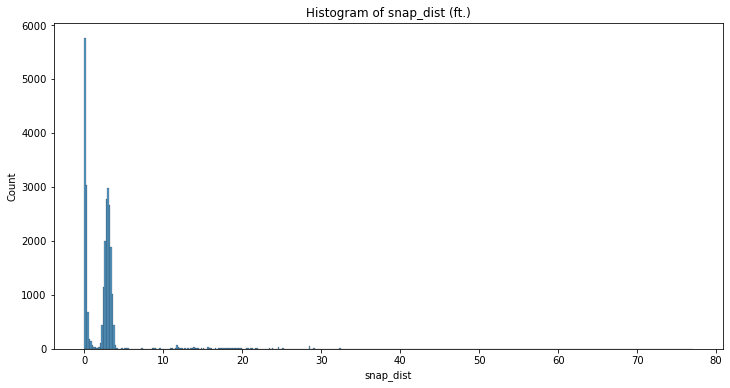

In [412]:
plt.figure(figsize=(12,6))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [413]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips  \
0            182    QN10         081   
352          182    QN10         081   
379          182    QN10         081   
424          182    QN10         081   
698          182    QN10         081   

                                               ntaname boro_name boro_code  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   

      line_i physicalid        st_label  st_name      full_stree rw_type  \
0    27601.0      14742      BCH 101 ST      101      BCH 101 ST       1   
352  97447.0      15155      BCH 149 ST    B 149        B 149 ST       1   
379  54349.0     167017      BCH 129 ST    B 129        B 129 ST       1   
424  14459.0      14638  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR       1   
698   9255.0     167021      BCH 129 ST    B 129        B 129 ST       1   

    rw_type_name st_width frm_lvl_co  
0         Street       30         13  
352       Street       30         13  
379       Street       30         13  
424       Street       32         13  
698       Street       30         13

In [414]:
updated_points.physicalid.value_counts()

76941     115
93488      91
44654      88
109590     81
23726      77
         ... 
5186        1
93895       1
94561       1
93578       1
86646       1
Name: physicalid, Length: 12799, dtype: int64

In [415]:
updated_points.physicalid.value_counts().index[0]

'76941'

In [416]:
top_street_id = updated_points.physicalid.value_counts().index[0]
print(top_street_id)

updated_points.loc[updated_points.physicalid == top_street_id].iloc[:, 30:45].head()

76941


index_right ntacode county_fips                 ntaname      boro_name  \
311           95    SI45         085  New Dorp-Midland Beach  Staten Island   
314           95    SI45         085  New Dorp-Midland Beach  Staten Island   
538           95    SI45         085  New Dorp-Midland Beach  Staten Island   
772           95    SI45         085  New Dorp-Midland Beach  Staten Island   
867           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code   line_i physicalid    st_label  st_name  full_stree rw_type  \
311         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
314         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
538         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
772         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
867         5  19421.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
311       Street       22         13  
314       Street       22         13  
538       Street       22         13  
772       Street       22         13  
867       Street       22         13

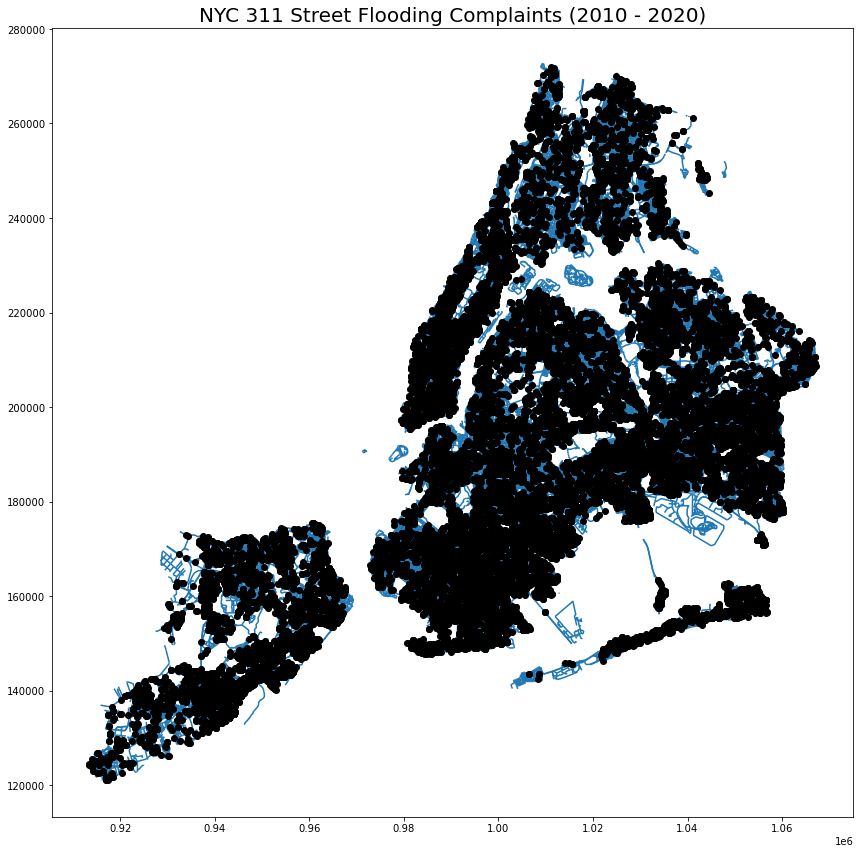

In [417]:
fig, ax = plt.subplots(figsize=(12, 12))

updated_points.plot(ax=ax, 
                    c='black')

streets.plot(ax=ax, 
             zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints (2010 - 2020)', 
             fontsize=20)

plt.tight_layout()

In [418]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [419]:
gdf_count.head()

physicalid  created_date
0     100002             2
1     100019             1
2     100020             1
3      10003             1
4      10004             2

In [420]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [421]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [422]:
streets[['geometry']].head()

geometry
0  LINESTRING (1047146.080 222733.432, 1047385.93...
1  LINESTRING (1009926.638 269075.549, 1010033.71...
2  LINESTRING (989292.818 189689.736, 989648.842 ...
3  LINESTRING (1031371.427 199453.863, 1031412.58...
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [423]:
streets.set_geometry('geometry', inplace=True)

In [424]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [425]:
streets['new_geom'] = streets.geometry.buffer(40, cap_style=2)

streets.set_geometry('new_geom', inplace=True)

In [426]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...  
2  POLYGON ((989665.155 189566.793, 989865.462 18...  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...  
4  POLYGON ((940041.585 144007.708, 940012.801 14...

In [427]:
streets.geom_type.value_counts()

Polygon         99328
MultiPolygon       34
dtype: int64

In [428]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
 12  new_geom      99362 non-null  geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 9.9+ MB


In [429]:
gdf_count.head()

physicalid  count
0     100002      2
1     100019      1
2     100020      1
3      10003      1
4      10004      2

In [430]:
gdf_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12799 entries, 0 to 12798
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   physicalid  12799 non-null  object
 1   count       12799 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 200.1+ KB


In [431]:
streets.shape

(99362, 13)

In [432]:
# joining our street data to our flood complaints data
streets_with_count = streets.merge(gdf_count, 
                                   left_on='physicalid', 
                                   right_on='physicalid', 
                                   how='left')

In [433]:
streets_with_count.shape

(99362, 14)

In [434]:
streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    NaN  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    NaN  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    NaN  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    NaN  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    NaN

In [435]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99362 entries, 0 to 99361
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
 12  new_geom      99362 non-null  geometry
 13  count         12799 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [436]:
streets_with_count.isna().sum()

physicalid          0
st_label            0
st_name             0
full_stree          0
rw_type             0
rw_type_name        0
st_width            0
frm_lvl_co          0
to_lvl_co           0
borocode            0
shape_leng          0
geometry            0
new_geom            0
count           86563
dtype: int64

In [437]:
streets_with_count['count'].fillna(0, inplace=True)

streets_with_count.isna().sum()

physicalid      0
st_label        0
st_name         0
full_stree      0
rw_type         0
rw_type_name    0
st_width        0
frm_lvl_co      0
to_lvl_co       0
borocode        0
shape_leng      0
geometry        0
new_geom        0
count           0
dtype: int64

In [438]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19421      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66852      93488       157 ST       157       157 ST       1       Street   
56685      44654      MILL RD      MILL      MILL RD       1       Street   
32081     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75666      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
19421       22         13        13        5  372.786118   
66852       35         13        13        4  499.592808   
56685       60         13        13        5  404.812891   
32081       22         13        13        3  554.170960   
75666       30         13        13        4  678.503925   

                                                geometry  \
19421  LINESTRING (958533.655 149022.834, 958315.338 ...   
66852  LINESTRING (1045395.099 182129.719, 1045149.50...   
56685  LINESTRING (952047.152 142027.684, 951841.926 ...   
32081  LINESTRING (1023855.973 183442.797, 1023962.32...   
75666  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  
19421  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0  
66852  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0  
56685  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0  
32081  POLYGON ((1024001.581 182906.603, 1023923.068 ...   81.0  
75666  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0

In [439]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 99362 entries, 0 to 99361
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
 12  new_geom      99362 non-null  geometry
 13  count         99362 non-null  float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 11.4+ MB


In [440]:
streets_with_count[['count']].describe()

count
count  99362.000000
mean       0.270355
std        1.409896
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      115.000000

In [441]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [442]:
streets_with_count[['shape_leng']].describe()

shape_leng
count  99362.000000
mean     846.090161
std      523.759151
min      160.000000
25%      550.726302
50%      689.657945
75%     1076.346415
max    30346.427123

In [443]:
streets_with_count.describe()

shape_leng         count
count  99362.000000  99362.000000
mean     846.090161      0.270355
std      523.759151      1.409896
min      160.000000      0.000000
25%      550.726302      0.000000
50%      689.657945      0.000000
75%     1076.346415      0.000000
max    30346.427123    115.000000

In [444]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0  
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0  
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0  
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0  
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0

In [445]:
streets_with_count[['count_per_100ft']].describe()

count_per_100ft
count     99362.000000
mean          0.032538
std           0.179189
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.704680

In [446]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid            st_label  st_name  full_stree rw_type  \
10769     155472            W 228 ST      228   W  228 ST       1   
19421      76941          GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
97517     173312          LORING AVE   LORING  LORING AVE       1   
59879      17823  FRANCIS LEWIS BLVD    LEWIS  LEWIS BLVD       1   
56685      44654             MILL RD     MILL     MILL RD       1   

      rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
10769       Street       44         13        13        1  183.615016   
19421       Street       22         13        13        5  905.572235   
97517       Street       30         13        13        3  643.111870   
59879       Street       20         13        13        4  650.977969   
56685       Street       60         13        13        5  969.625782   

                                                geometry  \
10769  LINESTRING (1009588.352 258326.086, 1009580.22...   
19421  LINESTRING (958533.655 149022.834, 958315.338 ...   
97517  LINESTRING (1023724.487 182856.704, 1023962.32...   
59879  LINESTRING (1056604.322 185833.195, 1056520.50...   
56685  LINESTRING (952047.152 142027.684, 951841.926 ...   

                                                new_geom  count  \
10769  POLYGON ((1009551.215 258307.106, 1009609.228 ...   27.0   
19421  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0   
97517  POLYGON ((1023955.332 182938.311, 1023969.316 ...   70.0   
59879  POLYGON ((1056557.484 185614.763, 1056555.807 ...   62.0   
56685  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0   

       count_per_100ft  
10769        14.704680  
19421        12.699153  
97517        10.884576  
59879         9.524132  
56685         9.075666

In [447]:
streets_with_count['count'].sum()

26863.0

In [448]:
streets_with_count.shape

(99362, 15)

# Joining streets to neighborhoods

In [449]:
updated_points.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
0                     NaN  ...       1       Street       30         13   
352                   NaN  ...       1       Street       30         13   
379                   NaN  ...       1       Street       30         13   
424                   NaN  ...       1       Street       32         13   
698                   NaN  ...       1       Street       30         13   

    to_lvl_co borocode  shape_leng                        geometry  \
0          13        4  137.778871  POINT (1033547.792 152391.390)   
352        13        4  474.577648  POINT (1021916.306 146938.462)   
379        13        4  719.484239  POINT (1026338.221 149465.426)   
424        13        4  531.467098  POINT (1029961.522 151612.564)   
698        13        4  796.665185  POINT (1026569.004 148943.676)   

                              point  snap_dist  
0    POINT (1033547.000 152391.000)   0.883029  
352  POINT (1021913.000 146937.000)   3.615168  
379  POINT (1026335.000 149464.000)   3.522517  
424  POINT (1029969.000 151595.000)  19.090046  
698  POINT (1026572.000 148945.000)   3.275558  

[5 rows x 51 columns]

In [450]:
updated_points.shape

(26863, 51)

In [451]:
updated_points.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'status',
       'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'index_right', 'ntacode', 'county_fips',
       'ntaname', 'boro_name', 'boro_code', 'line_i', 'physicalid', 'st_label',
       'st_name', 'full_stree', 'rw_type', 'rw_type_name', 'st_width',
       'frm_lvl_co', 'to_lvl_co', 'borocode', 'shape_leng', 'geometry',
       'point', 'snap_dist'],
      dtype='object')

In [452]:
streets_with_nta = updated_points[['unique_key', 
                                   'ntacode', 
                                   'county_fips',
                                   'ntaname', 
                                   'boro_name', 
                                   'boro_code', 
                                   'shape_leng', 
                                   'physicalid']]

streets_with_nta.head()

unique_key ntacode county_fips  \
0      31862075    QN10         081   
352    48315004    QN10         081   
379    48257821    QN10         081   
424    48351959    QN10         081   
698    47194494    QN10         081   

                                               ntaname boro_name boro_code  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...    Queens         4   

     shape_leng physicalid  
0    137.778871      14742  
352  474.577648      15155  
379  719.484239     167017  
424  531.467098      14638  
698  796.665185     167021

In [453]:
streets_with_nta.physicalid.value_counts()

76941     115
93488      91
44654      88
109590     81
23726      77
         ... 
5186        1
93895       1
94561       1
93578       1
86646       1
Name: physicalid, Length: 12799, dtype: int64

In [454]:
checking_for_duplicates = streets_with_nta.groupby(by=['physicalid', 
                                                       'ntaname', 
                                                       'boro_name'])['shape_leng'].count().reset_index()

checking_for_duplicates.head()

physicalid                  ntaname boro_name  shape_leng
0     100002           Queens Village    Queens           2
1     100019  Lindenwood-Howard Beach    Queens           1
2     100020  Lindenwood-Howard Beach    Queens           1
3      10003            East Elmhurst    Queens           1
4      10004            East Elmhurst    Queens           2

In [455]:
checking_for_duplicates.rename(columns={"shape_leng": "count_complaints"}, inplace=True)

checking_for_duplicates.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [456]:
checking_for_duplicates['physicalid'].is_unique

False

In [457]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=False).head(10)

physicalid                               ntaname      boro_name  \
12466      97041                               Jamaica         Queens   
12465      97041               Briarwood-Jamaica Hills         Queens   
12313       9550                       Jackson Heights         Queens   
12314       9550                          North Corona         Queens   
12190      94540                          Borough Park       Brooklyn   
12191      94540              Kensington-Ocean Parkway       Brooklyn   
11961      93176                              Rosedale         Queens   
11962      93176  Springfield Gardens South-Brookville         Queens   
11318      88110                New Dorp-Midland Beach  Staten Island   
11319      88110                 Oakwood-Oakwood Beach  Staten Island   

       count_complaints  
12466                 2  
12465                 1  
12313                 1  
12314                 1  
12190                 2  
12191                 1  
11961                 1  
11962                 1  
11318                 2  
11319                 1

In [458]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].sort_values(
                                                           by=['physicalid', 
                                                               'count_complaints'], 
                                                           ascending=[True, False]).head(10)

physicalid                      ntaname  boro_name  count_complaints
203     101556           Marble Hill-Inwood  Manhattan                 1
204     101556  park-cemetery-etc-Manhattan  Manhattan                 1
589      10779               Middle Village     Queens                 1
590      10779                    Ridgewood     Queens                 1
604     109590      Lindenwood-Howard Beach     Queens                56
603     109590                East New York   Brooklyn                25
644       1134                      Clinton  Manhattan                 5
645       1134        Midtown-Midtown South  Manhattan                 3
648       1138                      Clinton  Manhattan                 2
649       1138        Midtown-Midtown South  Manhattan                 1

In [459]:
checking_for_duplicates[checking_for_duplicates.duplicated(subset=['physicalid'], 
                                                           keep=False) == True].shape[0]

154

In [460]:
duplicates = (len(checking_for_duplicates[checking_for_duplicates.duplicated(subset=
                                                               ['physicalid'], 
                                                               keep=False) == True]) / len(streets_with_count) * 100)


round(duplicates, 2)

0.15

# There are 150 duplicates (.15% of total) of street segments to neighborhoods

In [461]:
checking_for_duplicates[checking_for_duplicates.physicalid == '109590'].sort_values(by=['physicalid', 
                                                                                        'count_complaints'], 
                                                                                   ascending=[True,
                                                                                              False])

physicalid                  ntaname boro_name  count_complaints
604     109590  Lindenwood-Howard Beach    Queens                56
603     109590            East New York  Brooklyn                25

# Sorting descending by number of complaints on a street in a given NTA. Then removing duplicates.

In [462]:
unique_streets = checking_for_duplicates.sort_values(by=['physicalid', 
                                                         'count_complaints'], 
                                                     ascending=[True, 
                                                                False]).drop_duplicates('physicalid')

In [463]:
unique_streets.head()

physicalid                  ntaname boro_name  count_complaints
0     100002           Queens Village    Queens                 2
1     100019  Lindenwood-Howard Beach    Queens                 1
2     100020  Lindenwood-Howard Beach    Queens                 1
3      10003            East Elmhurst    Queens                 1
4      10004            East Elmhurst    Queens                 2

In [464]:
unique_streets[unique_streets.physicalid == '109590']

physicalid                  ntaname boro_name  count_complaints
604     109590  Lindenwood-Howard Beach    Queens                56

In [465]:
unique_streets.physicalid.is_unique

True

In [466]:
streets_with_count.shape

(99362, 15)

In [467]:
# joining our nta population data to our nta shapes data
streets_with_count_nta = streets_with_count.merge(unique_streets, 
                                                  left_on='physicalid', 
                                                  right_on='physicalid', 
                                                  how='left')

streets_with_count_nta.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       35         13        13        4   677.719481   
1       Street       42         13        13        2  1069.865843   
2       Street       50         13        13        3  1378.848749   
3       Street       40         13        13        4   254.798456   
4       Street       36         13        13        5   696.457501   

                                            geometry  \
0  LINESTRING (1047146.080 222733.432, 1047385.93...   
1  LINESTRING (1009926.638 269075.549, 1010033.71...   
2  LINESTRING (989292.818 189689.736, 989648.842 ...   
3  LINESTRING (1031371.427 199453.863, 1031412.58...   
4  LINESTRING (940277.458 144141.538, 940027.193 ...   

                                            new_geom  count  count_per_100ft  \
0  POLYGON ((1047370.887 222867.857, 1047400.976 ...    0.0              0.0   
1  POLYGON ((1009994.841 269527.116, 1010072.594 ...    0.0              0.0   
2  POLYGON ((989665.155 189566.793, 989865.462 18...    0.0              0.0   
3  POLYGON ((1031432.423 199465.095, 1031392.753 ...    0.0              0.0   
4  POLYGON ((940041.585 144007.708, 940012.801 14...    0.0              0.0   

  ntaname boro_name  count_complaints  
0     NaN       NaN               NaN  
1     NaN       NaN               NaN  
2     NaN       NaN               NaN  
3     NaN       NaN               NaN  
4     NaN       NaN               NaN

In [468]:
streets_with_count_nta.iloc[:, -3:].describe(include='all')

ntaname boro_name  count_complaints
count         12799     12799      12799.000000
unique          194         5               NaN
top     Great Kills    Queens               NaN
freq            221      4824               NaN
mean            NaN       NaN          2.088757
std             NaN       NaN          3.353958
min             NaN       NaN          1.000000
25%             NaN       NaN          1.000000
50%             NaN       NaN          1.000000
75%             NaN       NaN          2.000000
max             NaN       NaN        115.000000

In [469]:
streets_with_count_nta.sort_values(by='count', ascending=False).head()

physicalid     st_label   st_name   full_stree rw_type rw_type_name  \
19421      76941   GRIMSBY ST   GRIMSBY   GRIMSBY ST       1       Street   
66852      93488       157 ST       157       157 ST       1       Street   
56685      44654      MILL RD      MILL      MILL RD       1       Street   
32081     109590  SAPPHIRE ST  SAPPHIRE  SAPPHIRE ST       1       Street   
75666      23726       141 ST       141       141 ST       1       Street   

      st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
19421       22         13        13        5   905.572235   
66852       35         13        13        4  1159.185617   
56685       60         13        13        5   969.625782   
32081       22         13        13        3  1268.341920   
75666       30         13        13        4  1517.007849   

                                                geometry  \
19421  LINESTRING (958533.655 149022.834, 958315.338 ...   
66852  LINESTRING (1045395.099 182129.719, 1045149.50...   
56685  LINESTRING (952047.152 142027.684, 951841.926 ...   
32081  LINESTRING (1023855.973 183442.797, 1023962.32...   
75666  LINESTRING (1039008.353 188480.375, 1039246.94...   

                                                new_geom  count  \
19421  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0   
66852  POLYGON ((1045184.342 181674.994, 1045114.676 ...   91.0   
56685  POLYGON ((951876.405 141658.470, 951807.447 14...   88.0   
32081  POLYGON ((1024001.581 182906.603, 1023923.068 ...   81.0   
75666  POLYGON ((1039284.394 187859.272, 1039209.503 ...   77.0   

       count_per_100ft                               ntaname      boro_name  \
19421        12.699153                New Dorp-Midland Beach  Staten Island   
66852         7.850339  Springfield Gardens South-Brookville         Queens   
56685         9.075666                 Oakwood-Oakwood Beach  Staten Island   
32081         6.386291               Lindenwood-Howard Beach         Queens   
75666         5.075781                          Baisley Park         Queens   

       count_complaints  
19421             115.0  
66852              91.0  
56685              88.0  
32081              56.0  
75666              77.0

In [470]:
streets_with_count_nta.shape

(99362, 18)

In [471]:
count_by_nta = streets_with_count_nta[['physicalid',
                                       'full_stree',
                                       'ntaname',
                                       'boro_name',
                                       'count',
                                       'count_per_100ft']]

In [472]:
count_by_nta.head()

physicalid       full_stree ntaname boro_name  count  count_per_100ft
0       6110           28 AVE     NaN       NaN    0.0              0.0
1      61140    ARLINGTON AVE     NaN       NaN    0.0              0.0
2     145494  SCHERMERHORN ST     NaN       NaN    0.0              0.0
3      12438      QUEENS BLVD     NaN       NaN    0.0              0.0
4      15432    ARTHUR KIL RD     NaN       NaN    0.0              0.0

In [473]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19421      76941   GRIMSBY ST                New Dorp-Midland Beach   
66852      93488       157 ST  Springfield Gardens South-Brookville   
56685      44654      MILL RD                 Oakwood-Oakwood Beach   
32081     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75666      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  
19421  Staten Island  115.0        12.699153  
66852         Queens   91.0         7.850339  
56685  Staten Island   88.0         9.075666  
32081         Queens   81.0         6.386291  
75666         Queens   77.0         5.075781

In [474]:
count_by_nta.sort_values(by='count_per_100ft', ascending=False).head()

physicalid  full_stree                 ntaname      boro_name  count  \
10769     155472   W  228 ST      Marble Hill-Inwood      Manhattan   27.0   
19421      76941  GRIMSBY ST  New Dorp-Midland Beach  Staten Island  115.0   
97517     173312  LORING AVE           East New York       Brooklyn   70.0   
59879      17823  LEWIS BLVD               Laurelton         Queens   62.0   
56685      44654     MILL RD   Oakwood-Oakwood Beach  Staten Island   88.0   

       count_per_100ft  
10769        14.704680  
19421        12.699153  
97517        10.884576  
59879         9.524132  
56685         9.075666

In [475]:
count_by_nta.physicalid.is_unique

True

In [476]:
count_by_nta.describe()

count  count_per_100ft
count  99362.000000     99362.000000
mean       0.270355         0.032538
std        1.409896         0.179189
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      115.000000        14.704680

# sanity check

In [477]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().sort_values(
                                by='count', 
                                ascending=False).head()

physicalid   full_stree  count  count_per_100ft
78462      76941   GRIMSBY ST  115.0        12.699153
93384      93488       157 ST   91.0         7.850339
47817      44654      MILL RD   88.0         9.075666
5604      109590  SAPPHIRE ST   81.0         6.386291
27459      23726       141 ST   77.0         5.075781

In [478]:
streets_with_count.groupby(by=['physicalid',
                               'full_stree'])[[
                               'count', 
                               'count_per_100ft']].sum().reset_index().describe()

count  count_per_100ft
count  99362.000000     99362.000000
mean       0.270355         0.032538
std        1.409896         0.179189
min        0.000000         0.000000
25%        0.000000         0.000000
50%        0.000000         0.000000
75%        0.000000         0.000000
max      115.000000        14.704680

# adding nta information

In [479]:
count_by_nta['with_nta_name'] = count_by_nta['full_stree'] + ", " + count_by_nta['ntaname'] + ", " + count_by_nta['boro_name']

/Users/geribauer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [480]:
count_by_nta.sort_values(by='count', ascending=False).head()

physicalid   full_stree                               ntaname  \
19421      76941   GRIMSBY ST                New Dorp-Midland Beach   
66852      93488       157 ST  Springfield Gardens South-Brookville   
56685      44654      MILL RD                 Oakwood-Oakwood Beach   
32081     109590  SAPPHIRE ST               Lindenwood-Howard Beach   
75666      23726       141 ST                          Baisley Park   

           boro_name  count  count_per_100ft  \
19421  Staten Island  115.0        12.699153   
66852         Queens   91.0         7.850339   
56685  Staten Island   88.0         9.075666   
32081         Queens   81.0         6.386291   
75666         Queens   77.0         5.075781   

                                           with_nta_name  
19421  GRIMSBY ST, New Dorp-Midland Beach, Staten Island  
66852  157 ST, Springfield Gardens South-Brookville, ...  
56685      MILL RD, Oakwood-Oakwood Beach, Staten Island  
32081       SAPPHIRE ST, Lindenwood-Howard Beach, Queens  
75666                       141 ST, Baisley Park, Queens

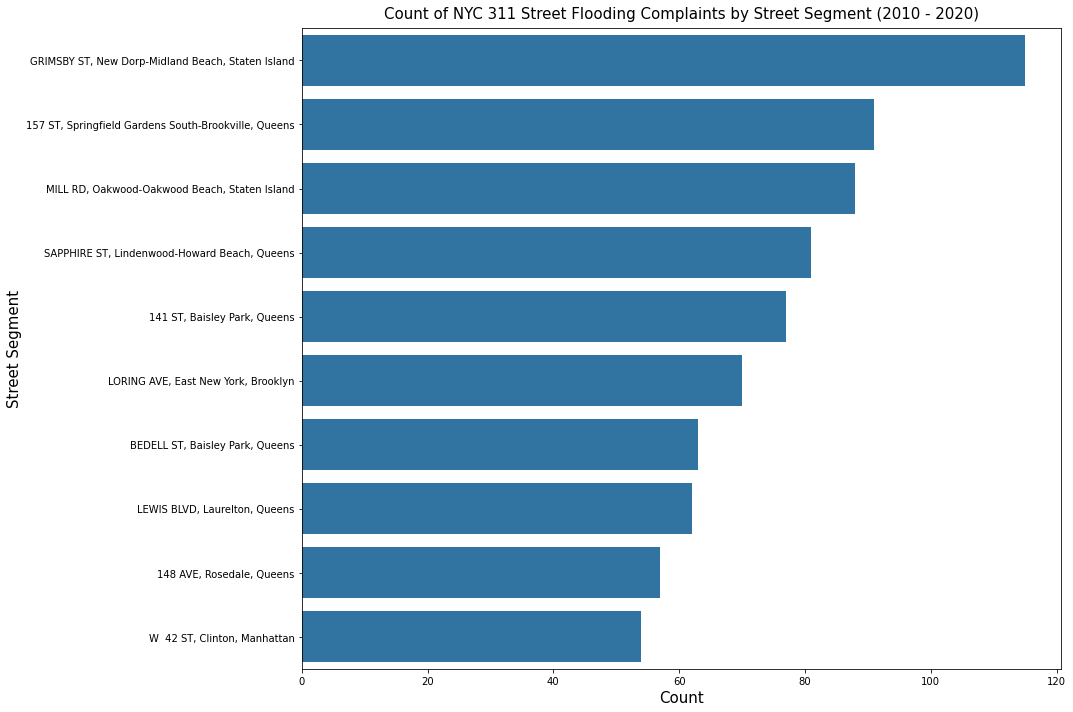

In [481]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

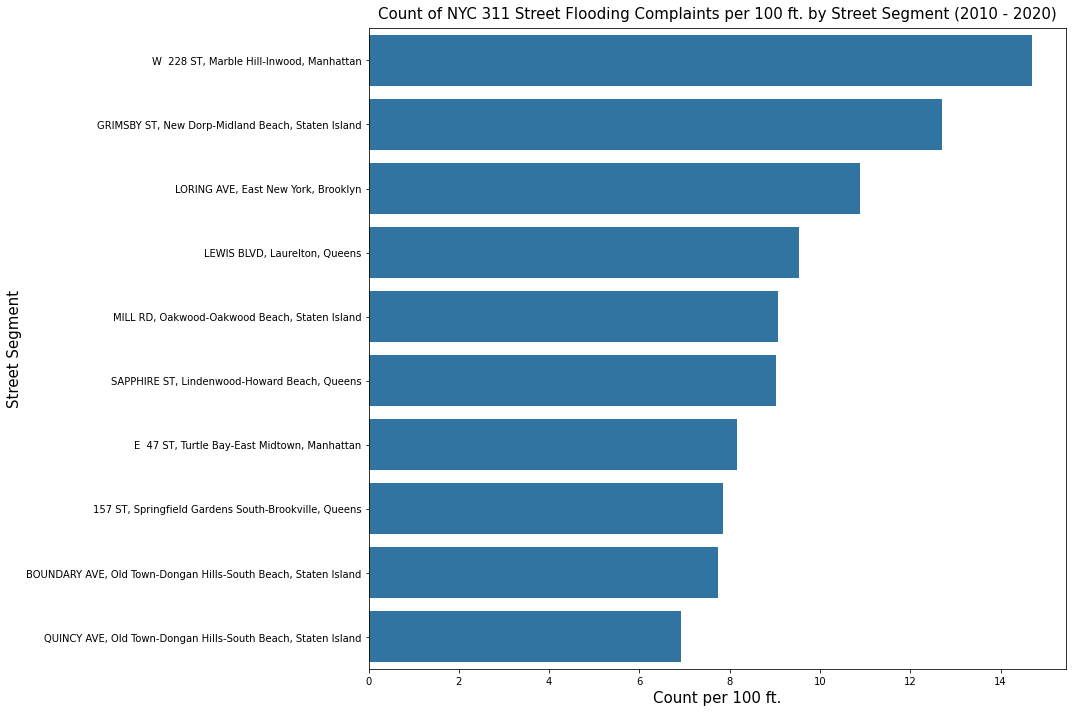

In [482]:
plt.figure(figsize=(15,10))

sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count per 100 ft.', fontsize=15)
plt.ylabel('Street Segment', fontsize=15)
plt.tight_layout()

plt.savefig('figures/count_per_length.png')

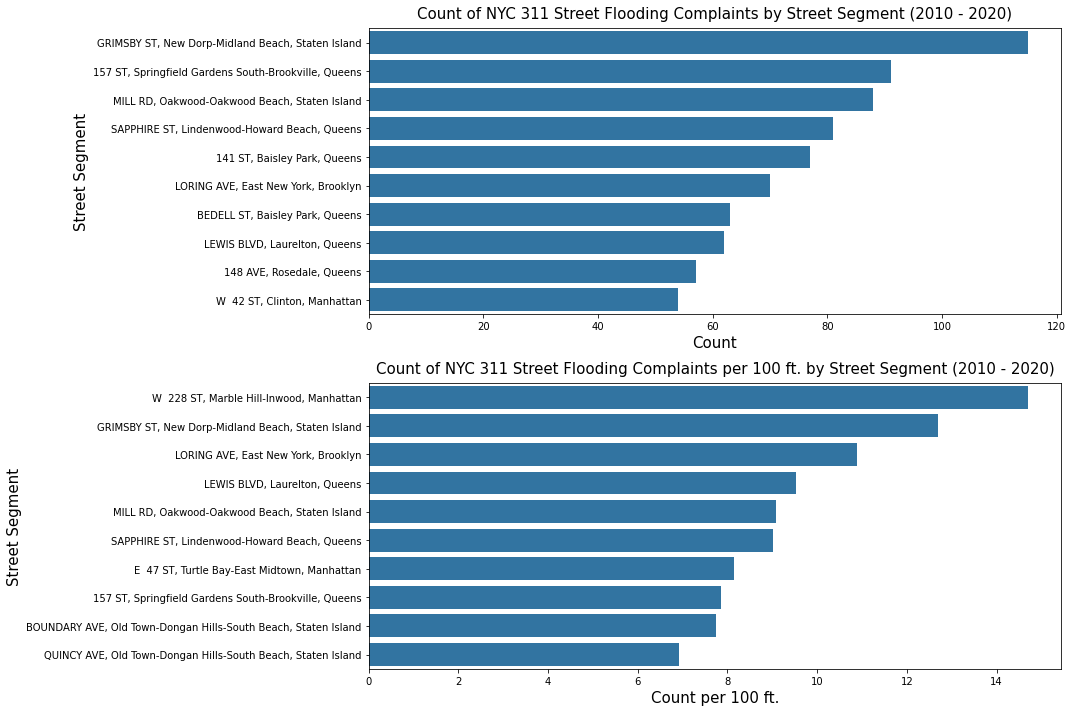

In [483]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=count_by_nta.sort_values(by='count', ascending=False).head(10),
            y='with_nta_name',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=15)
axs[0].set_ylabel('Street Segment', fontsize=15)

# second plot
sns.barplot(data=count_by_nta.sort_values(by='count_per_100ft', ascending=False).head(10),
            y='with_nta_name',
            x='count_per_100ft',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment (2010 - 2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per 100 ft.', fontsize=15)
axs[1].set_ylabel('Street Segment', fontsize=15)

plt.tight_layout()
plt.savefig('figures/pres-15.png')

In [484]:
count_by_nta.to_csv('data-output/streets-with-count.csv', index=False)

## Case Studies

## 1) Hammels, Arverne, and Edgemere, Queens and 2) New Dorp - Midland Beach, Staten Island

In [485]:
top_nta = gpd.GeoDataFrame(flooding_311, 
                           geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                       flooding_311.y_coordinate_state_plane))

top_nta.head()

unique_key             created_date              closed_date agency  \
0    31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
1    25163797  2013-03-12T12:38:00.000  2013-03-12T14:20:00.000    DEP   
2    25185984  2013-03-15T12:13:00.000  2013-03-18T14:15:00.000    DEP   
3    25187738  2013-03-15T12:20:00.000  2013-03-15T14:22:00.000    DEP   
4    25338491  2013-04-11T12:16:00.000  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11694.0                   NaN   
1  Street Flooding (SJ)       11236.0                   NaN   
2  Street Flooding (SJ)       11236.0                   NaN   
3  Street Flooding (SJ)       11236.0                   NaN   
4  Street Flooding (SJ)       11236.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0                   NaN  ...       QUEENS  40.584819 -73.822517   
1                   NaN  ...     BROOKLYN        NaN        NaN   
2                   NaN  ...     BROOKLYN        NaN        NaN   
3                   NaN  ...     BROOKLYN        NaN        NaN   
4                   NaN  ...     BROOKLYN        NaN        NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  \
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN   
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   

                         geometry  
0  POINT (1033547.000 152391.000)  
1  POINT (1010685.000 171510.000)  
2  POINT (1010685.000 171510.000)  
3  POINT (1010685.000 171510.000)  
4  POINT (1010685.000 171510.000)  

[5 rows x 31 columns]

In [486]:
top_nta.set_crs(epsg=2263, inplace=True)
top_nta.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

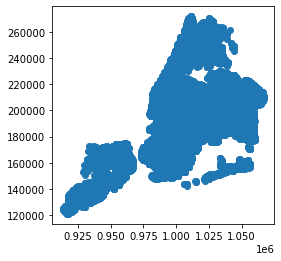

In [487]:
top_nta.plot()

In [488]:
gdf.shape

(26923, 36)

In [489]:
top_nta = gpd.sjoin(top_nta, 
                    nta_shape, 
                    how="inner", 
                    op='within')

In [490]:
top_nta.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ...           bbl                        geometry  \
0                     NaN  ...           NaN  POINT (1033547.000 152391.000)   
352                   NaN  ...  4.163140e+09  POINT (1021913.000 146937.000)   
379                   NaN  ...  4.162250e+09  POINT (1026335.000 149464.000)   
424                   NaN  ...  4.161660e+09  POINT (1029969.000 151595.000)   
698                   NaN  ...  4.162380e+09  POINT (1026572.000 148945.000)   

    index_right ntacode     shape_area county_fips  \
0           182    QN10  100209724.039         081   
352         182    QN10  100209724.039         081   
379         182    QN10  100209724.039         081   
424         182    QN10  100209724.039         081   
698         182    QN10  100209724.039         081   

                                               ntaname     shape_leng  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   

     boro_name boro_code  
0       Queens         4  
352     Queens         4  
379     Queens         4  
424     Queens         4  
698     Queens         4  

[5 rows x 39 columns]

# Neighborhoods with the most street flooding complaints

In [491]:
top_nta.groupby(by='ntaname')['unique_key'].count().reset_index().sort_values('unique_key', ascending=False).head(2)

ntaname  unique_key
116    New Dorp-Midland Beach         763
80   Hammels-Arverne-Edgemere         696

## Hammels, Arverne, and Edgemere, Queens

In [492]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [493]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
1    25163797  2013-03-12T12:38:00.000  2013-03-12T14:20:00.000    DEP   
2    25185984  2013-03-15T12:13:00.000  2013-03-18T14:15:00.000    DEP   
3    25187738  2013-03-15T12:20:00.000  2013-03-15T14:22:00.000    DEP   
4    25338491  2013-04-11T12:16:00.000  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11694.0                   NaN   
1  Street Flooding (SJ)       11236.0                   NaN   
2  Street Flooding (SJ)       11236.0                   NaN   
3  Street Flooding (SJ)       11236.0                   NaN   
4  Street Flooding (SJ)       11236.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0                   NaN  ...       QUEENS  40.584819 -73.822517   
1                   NaN  ...     BROOKLYN        NaN        NaN   
2                   NaN  ...     BROOKLYN        NaN        NaN   
3                   NaN  ...     BROOKLYN        NaN        NaN   
4                   NaN  ...     BROOKLYN        NaN        NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  \
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN   
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   

                         geometry  
0  POINT (1033547.000 152391.000)  
1  POINT (1010685.000 171510.000)  
2  POINT (1010685.000 171510.000)  
3  POINT (1010685.000 171510.000)  
4  POINT (1010685.000 171510.000)  

[5 rows x 31 columns]

In [494]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

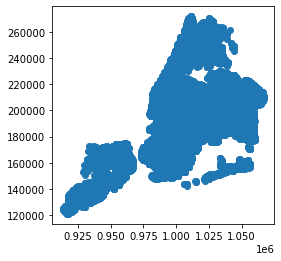

In [495]:
gdf.plot()

In [496]:
gdf.shape

(26925, 31)

In [497]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [498]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ...           bbl                        geometry  \
0                     NaN  ...           NaN  POINT (1033547.000 152391.000)   
352                   NaN  ...  4.163140e+09  POINT (1021913.000 146937.000)   
379                   NaN  ...  4.162250e+09  POINT (1026335.000 149464.000)   
424                   NaN  ...  4.161660e+09  POINT (1029969.000 151595.000)   
698                   NaN  ...  4.162380e+09  POINT (1026572.000 148945.000)   

    index_right ntacode     shape_area county_fips  \
0           182    QN10  100209724.039         081   
352         182    QN10  100209724.039         081   
379         182    QN10  100209724.039         081   
424         182    QN10  100209724.039         081   
698         182    QN10  100209724.039         081   

                                               ntaname     shape_leng  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   

     boro_name boro_code  
0       Queens         4  
352     Queens         4  
379     Queens         4  
424     Queens         4  
698     Queens         4  

[5 rows x 39 columns]

In [499]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [500]:
ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [501]:
path = 'data-raw/raw-streets-clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [502]:
streets.shape

(99362, 12)

<AxesSubplot:>

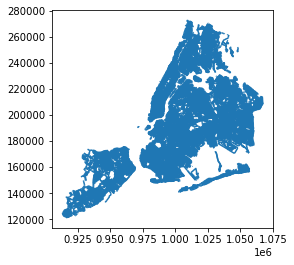

In [503]:
streets.plot()

In [504]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [505]:
streets.describe()

shape_leng
count  9.936200e+04
mean   3.431188e+02
std    2.620211e+02
min    1.068681e-08
25%    1.953735e+02
50%    2.648459e+02
75%    4.583545e+02
max    1.509366e+04

In [506]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [507]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [508]:
Hammels_Arverne_Edgemere = nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere']

In [509]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, Hammels_Arverne_Edgemere)

<AxesSubplot:>

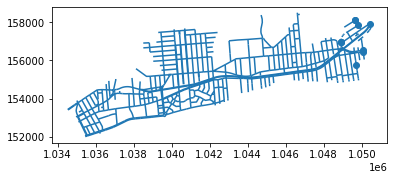

In [510]:
streets_clipped.plot()

In [511]:
streets_clipped.geom_type.value_counts()

LineString            843
Point                   9
MultiLineString         2
GeometryCollection      1
dtype: int64

In [512]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [513]:
# clipping the school points that only fall within the nta shapes
Hammels_Arverne_Edgemere = gpd.clip(gdf, 
                                    Hammels_Arverne_Edgemere)

<AxesSubplot:>

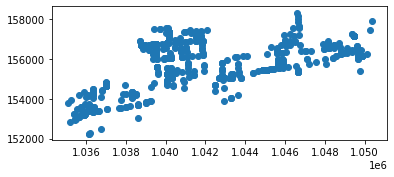

In [514]:
Hammels_Arverne_Edgemere.plot()

In [515]:
Hammels_Arverne_Edgemere.geom_type.value_counts()

Point    696
dtype: int64

# Snap points to streets

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [516]:
streets_clipped.sindex

rtree.index.Index(bounds=[1034529.2977429869, 151996.05628808722, 1050540.0391240292, 158513.33282463337], size=843)

In [517]:
offset = 80

bbox = Hammels_Arverne_Edgemere.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny       maxx      maxy
6   1038227.0  154276.0  1038387.0  154436.0
12  1038227.0  154276.0  1038387.0  154436.0
20  1040287.0  154573.0  1040447.0  154733.0
21  1038123.0  153534.0  1038283.0  153694.0
59  1042786.0  154996.0  1042946.0  155156.0

In [518]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

6                                         [10, 613]
12                                        [10, 613]
20    [292, 625, 725, 508, 146, 358, 377, 112, 471]
21                                            [167]
59          [779, 446, 41, 507, 389, 161, 816, 117]
dtype: object

In [519]:
hits.shape

(696,)

In [520]:
tmp = pd.DataFrame(
    {
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [521]:
tmp.head()

pt_idx  line_i
0       6    10.0
1       6   613.0
2      12    10.0
3      12   613.0
4      20   292.0

In [522]:
tmp.shape

(2141, 2)

In [523]:
streets_clipped.shape

(843, 12)

In [524]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
252       14294            BCH 74 ST            B 74             B 74 ST   
347       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
506      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1016      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
252        1       Street       30         13        13        4  623.015421   
347        1       Street       35         13        13        4  234.071915   
506        1       Street       31         13        13        4  255.930554   
1016       1       Street       24         13        13        4  186.284190   

                                               geometry  
41    LINESTRING (1041022.181 156864.681, 1040981.69...  
252   LINESTRING (1039173.301 154571.323, 1039121.22...  
347   LINESTRING (1046371.747 155628.532, 1046139.47...  
506   LINESTRING (1041944.905 154892.163, 1041702.46...  
1016  LINESTRING (1036423.096 153354.452, 1036408.71...

In [525]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), 
               on="line_i")

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0       6    10.0      14165  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
1       6   613.0     172255     BCH 79 ST      B 79       B 79 ST       1   
2      12    10.0      14165  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
3      12   613.0     172255     BCH 79 ST      B 79       B 79 ST       1   
4      20   292.0     127599     BCH 69 ST      B 69       B 69 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street        0         13        13        4  233.399813   
1       Street       25         13        13        4  244.994073   
2       Street        0         13        13        4  233.399813   
3       Street       25         13        13        4  244.994073   
4       Street       40         13        13        4  213.369256   

                                            geometry  
0  LINESTRING (1038540.156 154410.783, 1038316.87...  
1  LINESTRING (1038297.735 154234.529, 1038315.70...  
2  LINESTRING (1038540.156 154410.783, 1038316.87...  
3  LINESTRING (1038297.735 154234.529, 1038315.70...  
4  LINESTRING (1040389.946 154374.288, 1040372.79...

In [526]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(Hammels_Arverne_Edgemere.geometry.rename("point"), 
               on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, 
                       geometry="geometry", 
                       crs=Hammels_Arverne_Edgemere.crs)

In [527]:
tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0       6    10.0      14165  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
1       6   613.0     172255     BCH 79 ST      B 79       B 79 ST       1   
2      12    10.0      14165  ROCKAWAY FWY  ROCKAWAY  ROCKAWAY FWY       1   
3      12   613.0     172255     BCH 79 ST      B 79       B 79 ST       1   
4      20   292.0     127599     BCH 69 ST      B 69       B 69 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street        0         13        13        4  233.399813   
1       Street       25         13        13        4  244.994073   
2       Street        0         13        13        4  233.399813   
3       Street       25         13        13        4  244.994073   
4       Street       40         13        13        4  213.369256   

                                            geometry  \
0  LINESTRING (1038540.156 154410.783, 1038316.87...   
1  LINESTRING (1038297.735 154234.529, 1038315.70...   
2  LINESTRING (1038540.156 154410.783, 1038316.87...   
3  LINESTRING (1038297.735 154234.529, 1038315.70...   
4  LINESTRING (1040389.946 154374.288, 1040372.79...   

                            point  
0  POINT (1038307.000 154356.000)  
1  POINT (1038307.000 154356.000)  
2  POINT (1038307.000 154356.000)  
3  POINT (1038307.000 154356.000)  
4  POINT (1040367.000 154653.000)

In [528]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2141.000000
mean     32.960082
std      49.775521
min       0.004010
25%       0.491634
50%       7.268701
75%      57.602492
max     377.414126

In [529]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid        st_label  st_name      full_stree  \
1367   18397   312.0      14365  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   
1179   14829   413.0      80917       BCH 48 ST       48       BCH 48 ST   
930    13721   413.0      80917       BCH 48 ST       48       BCH 48 ST   
621     9414   413.0      80917       BCH 48 ST       48       BCH 48 ST   
1024   14676   334.0      14195  BCH CHANNEL DR  CHANNEL  BCH CHANNEL DR   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
1367       1       Street       50         13        13        4  261.689492   
1179       1       Street       30         13        13        4  570.432126   
930        1       Street       30         13        13        4  570.432126   
621        1       Street       30         13        13        4  570.432126   
1024       1       Street       52         13        13        4  308.269676   

                                               geometry  \
1367  LINESTRING (1043336.353 156058.630, 1043104.72...   
1179  LINESTRING (1045615.013 156289.929, 1045564.12...   
930   LINESTRING (1045615.013 156289.929, 1045564.12...   
621   LINESTRING (1045615.013 156289.929, 1045564.12...   
1024  LINESTRING (1038297.735 154234.529, 1037989.55...   

                               point  snap_dist  
1367  POINT (1043105.000 155937.000)   0.004010  
1179  POINT (1045615.000 156290.000)   0.006761  
930   POINT (1045615.000 156290.000)   0.006761  
621   POINT (1045615.000 156290.000)   0.006761  
1024  POINT (1037990.000 154242.000)   0.011789

In [530]:
tmp[['snap_dist']].describe()

snap_dist
count  1846.000000
mean     17.013918
std      23.916537
min       0.004010
25%       0.446798
50%       3.184132
75%      21.744168
max      78.864107

In [531]:
# group by the index of the points and take the first, which is the closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid             st_label         st_name  \
pt_idx                                                           
6        613.0     172255            BCH 79 ST            B 79   
12       613.0     172255            BCH 79 ST            B 79   
20       358.0     168842            BCH 69 ST            B 69   
21       167.0      14072  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
59       446.0      14345            BCH 59 ST            B 59   

                full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
pt_idx                                                                          
6                  B 79 ST       1       Street       25         13        13   
12                 B 79 ST       1       Street       25         13        13   
20                 B 69 ST       1       Street       45         13        13   
21      ROCKAWAY BEACH AVE       1       Street       53         13        13   
59                 B 59 ST       1       Street       50         13        13   

       borocode  shape_leng  \
pt_idx                        
6             4  244.994073   
12            4  244.994073   
20            4   85.481837   
21            4  337.450393   
59            4  530.833363   

                                                 geometry  \
pt_idx                                                      
6       LINESTRING (1038297.735 154234.529, 1038315.70...   
12      LINESTRING (1038297.735 154234.529, 1038315.70...   
20      LINESTRING (1040369.991 154622.014, 1040363.19...   
21      LINESTRING (1038370.438 153639.065, 1038036.66...   
59      LINESTRING (1042915.547 154547.878, 1042866.31...   

                                 point  snap_dist  
pt_idx                                             
6       POINT (1038307.000 154356.000)   0.254744  
12      POINT (1038307.000 154356.000)   0.254744  
20      POINT (1040367.000 154653.000)   0.516464  
21      POINT (1038203.000 153614.000)   0.148521  
59      POINT (1042866.000 155076.000)   0.354548

In [532]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
6     POINT (1038307.254 154355.980)
12    POINT (1038307.254 154355.980)
20    POINT (1040367.515 154653.041)
21    POINT (1038202.978 153614.147)
59    POINT (1042866.353 155076.033)
dtype: geometry

In [533]:
# Create a new GeoDataFrame from the columns from the closest line and 
# new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, 
                           geometry=new_pts)

snapped.head()

line_i physicalid             st_label         st_name  \
pt_idx                                                           
6        613.0     172255            BCH 79 ST            B 79   
12       613.0     172255            BCH 79 ST            B 79   
20       358.0     168842            BCH 69 ST            B 69   
21       167.0      14072  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
59       446.0      14345            BCH 59 ST            B 59   

                full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
pt_idx                                                                          
6                  B 79 ST       1       Street       25         13        13   
12                 B 79 ST       1       Street       25         13        13   
20                 B 69 ST       1       Street       45         13        13   
21      ROCKAWAY BEACH AVE       1       Street       53         13        13   
59                 B 59 ST       1       Street       50         13        13   

       borocode  shape_leng                        geometry  \
pt_idx                                                        
6             4  244.994073  POINT (1038307.254 154355.980)   
12            4  244.994073  POINT (1038307.254 154355.980)   
20            4   85.481837  POINT (1040367.515 154653.041)   
21            4  337.450393  POINT (1038202.978 153614.147)   
59            4  530.833363  POINT (1042866.353 155076.033)   

                                 point  snap_dist  
pt_idx                                             
6       POINT (1038307.000 154356.000)   0.254744  
12      POINT (1038307.000 154356.000)   0.254744  
20      POINT (1040367.000 154653.000)   0.516464  
21      POINT (1038203.000 153614.000)   0.148521  
59      POINT (1042866.000 155076.000)   0.354548

In [534]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
6     25354934  2013-04-13T08:36:00.000  2013-04-14T10:30:00.000    DEP   
12    28275296  2014-06-17T11:32:00.000  2014-06-17T11:40:00.000    DEP   
20    32637610  2016-02-09T09:03:00.000  2016-02-09T13:13:00.000    DEP   
21    32631343  2016-02-08T08:17:00.000  2016-02-08T10:06:00.000    DEP   
59    38597615  2018-03-03T22:23:00.000  2018-03-04T13:50:00.000    DEP   

                               agency_name complaint_type  \
6   Department of Environmental Protection          Sewer   
12  Department of Environmental Protection          Sewer   
20  Department of Environmental Protection          Sewer   
21  Department of Environmental Protection          Sewer   
59  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
6   Street Flooding (SJ)       11693.0                   NaN   
12  Street Flooding (SJ)       11693.0                   NaN   
20  Street Flooding (SJ)       11692.0                   NaN   
21  Street Flooding (SJ)       11693.0                   NaN   
59  Street Flooding (SJ)       11692.0       BEACH 59 STREET   

       intersection_street_2  ...       cross_street_1       cross_street_2  \
6                        NaN  ...  BEACH CHANNEL DRIVE     ROCKAWAY FREEWAY   
12                       NaN  ...  BEACH CHANNEL DRIVE     ROCKAWAY FREEWAY   
20                       NaN  ...     ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE   
21                       NaN  ...      BEACH 79 STREET      BEACH 80 STREET   
59  ROCKAWAY BEACH BOULEVARD  ...          BEACH 59 ST  ROCKAWAY BEACH BLVD   

   bbl                        geometry index_right ntacode county_fips  \
6  NaN  POINT (1038307.000 154356.000)         131    QN12         081   
12 NaN  POINT (1038307.000 154356.000)         131    QN12         081   
20 NaN  POINT (1040367.000 154653.000)         131    QN12         081   
21 NaN  POINT (1038203.000 153614.000)         131    QN12         081   
59 NaN  POINT (1042866.000 155076.000)         131    QN12         081   

                     ntaname  boro_name boro_code  
6   Hammels-Arverne-Edgemere     Queens         4  
12  Hammels-Arverne-Edgemere     Queens         4  
20  Hammels-Arverne-Edgemere     Queens         4  
21  Hammels-Arverne-Edgemere     Queens         4  
59  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 37 columns]

In [535]:
Hammels_Arverne_Edgemere.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 696 entries, 6 to 27807
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      696 non-null    int64   
 1   created_date                    696 non-null    object  
 2   closed_date                     696 non-null    object  
 3   agency                          696 non-null    object  
 4   agency_name                     696 non-null    object  
 5   complaint_type                  696 non-null    object  
 6   descriptor                      696 non-null    object  
 7   incident_zip                    696 non-null    float64 
 8   intersection_street_1           208 non-null    object  
 9   intersection_street_2           208 non-null    object  
 10  address_type                    696 non-null    object  
 11  city                            696 non-null    object  
 12  status      

In [536]:
Hammels_Arverne_Edgemere.drop(columns=["geometry"], inplace=True)

In [537]:
Hammels_Arverne_Edgemere.head()

unique_key             created_date              closed_date agency  \
6     25354934  2013-04-13T08:36:00.000  2013-04-14T10:30:00.000    DEP   
12    28275296  2014-06-17T11:32:00.000  2014-06-17T11:40:00.000    DEP   
20    32637610  2016-02-09T09:03:00.000  2016-02-09T13:13:00.000    DEP   
21    32631343  2016-02-08T08:17:00.000  2016-02-08T10:06:00.000    DEP   
59    38597615  2018-03-03T22:23:00.000  2018-03-04T13:50:00.000    DEP   

                               agency_name complaint_type  \
6   Department of Environmental Protection          Sewer   
12  Department of Environmental Protection          Sewer   
20  Department of Environmental Protection          Sewer   
21  Department of Environmental Protection          Sewer   
59  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
6   Street Flooding (SJ)       11693.0                   NaN   
12  Street Flooding (SJ)       11693.0                   NaN   
20  Street Flooding (SJ)       11692.0                   NaN   
21  Street Flooding (SJ)       11693.0                   NaN   
59  Street Flooding (SJ)       11692.0       BEACH 59 STREET   

       intersection_street_2  ...               street_name  \
6                        NaN  ...           BEACH 79 STREET   
12                       NaN  ...           BEACH 79 STREET   
20                       NaN  ...           BEACH 69 STREET   
21                       NaN  ...  ROCKAWAY BEACH BOULEVARD   
59  ROCKAWAY BEACH BOULEVARD  ...                       NaN   

         cross_street_1       cross_street_2 bbl index_right ntacode  \
6   BEACH CHANNEL DRIVE     ROCKAWAY FREEWAY NaN         131    QN12   
12  BEACH CHANNEL DRIVE     ROCKAWAY FREEWAY NaN         131    QN12   
20     ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE NaN         131    QN12   
21      BEACH 79 STREET      BEACH 80 STREET NaN         131    QN12   
59          BEACH 59 ST  ROCKAWAY BEACH BLVD NaN         131    QN12   

   county_fips                   ntaname  boro_name boro_code  
6          081  Hammels-Arverne-Edgemere     Queens         4  
12         081  Hammels-Arverne-Edgemere     Queens         4  
20         081  Hammels-Arverne-Edgemere     Queens         4  
21         081  Hammels-Arverne-Edgemere     Queens         4  
59         081  Hammels-Arverne-Edgemere     Queens         4  

[5 rows x 36 columns]

In [538]:
snapped.head()

line_i physicalid             st_label         st_name  \
pt_idx                                                           
6        613.0     172255            BCH 79 ST            B 79   
12       613.0     172255            BCH 79 ST            B 79   
20       358.0     168842            BCH 69 ST            B 69   
21       167.0      14072  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
59       446.0      14345            BCH 59 ST            B 59   

                full_stree rw_type rw_type_name st_width frm_lvl_co to_lvl_co  \
pt_idx                                                                          
6                  B 79 ST       1       Street       25         13        13   
12                 B 79 ST       1       Street       25         13        13   
20                 B 69 ST       1       Street       45         13        13   
21      ROCKAWAY BEACH AVE       1       Street       53         13        13   
59                 B 59 ST       1       Street       50         13        13   

       borocode  shape_leng                        geometry  \
pt_idx                                                        
6             4  244.994073  POINT (1038307.254 154355.980)   
12            4  244.994073  POINT (1038307.254 154355.980)   
20            4   85.481837  POINT (1040367.515 154653.041)   
21            4  337.450393  POINT (1038202.978 153614.147)   
59            4  530.833363  POINT (1042866.353 155076.033)   

                                 point  snap_dist  
pt_idx                                             
6       POINT (1038307.000 154356.000)   0.254744  
12      POINT (1038307.000 154356.000)   0.254744  
20      POINT (1040367.000 154653.000)   0.516464  
21      POINT (1038203.000 153614.000)   0.148521  
59      POINT (1042866.000 155076.000)   0.354548

In [539]:
# Join back to the original points:
updated_points = Hammels_Arverne_Edgemere.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
6     25354934  2013-04-13T08:36:00.000  2013-04-14T10:30:00.000    DEP   
12    28275296  2014-06-17T11:32:00.000  2014-06-17T11:40:00.000    DEP   
20    32637610  2016-02-09T09:03:00.000  2016-02-09T13:13:00.000    DEP   
21    32631343  2016-02-08T08:17:00.000  2016-02-08T10:06:00.000    DEP   
59    38597615  2018-03-03T22:23:00.000  2018-03-04T13:50:00.000    DEP   

                               agency_name complaint_type  \
6   Department of Environmental Protection          Sewer   
12  Department of Environmental Protection          Sewer   
20  Department of Environmental Protection          Sewer   
21  Department of Environmental Protection          Sewer   
59  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
6   Street Flooding (SJ)       11693.0                   NaN   
12  Street Flooding (SJ)       11693.0                   NaN   
20  Street Flooding (SJ)       11692.0                   NaN   
21  Street Flooding (SJ)       11693.0                   NaN   
59  Street Flooding (SJ)       11692.0       BEACH 59 STREET   

       intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
6                        NaN  ...       1       Street       25         13   
12                       NaN  ...       1       Street       25         13   
20                       NaN  ...       1       Street       45         13   
21                       NaN  ...       1       Street       53         13   
59  ROCKAWAY BEACH BOULEVARD  ...       1       Street       50         13   

   to_lvl_co borocode  shape_leng                        geometry  \
6         13        4  244.994073  POINT (1038307.254 154355.980)   
12        13        4  244.994073  POINT (1038307.254 154355.980)   
20        13        4   85.481837  POINT (1040367.515 154653.041)   
21        13        4  337.450393  POINT (1038202.978 153614.147)   
59        13        4  530.833363  POINT (1042866.353 155076.033)   

                             point snap_dist  
6   POINT (1038307.000 154356.000)  0.254744  
12  POINT (1038307.000 154356.000)  0.254744  
20  POINT (1040367.000 154653.000)  0.516464  
21  POINT (1038203.000 153614.000)  0.148521  
59  POINT (1042866.000 155076.000)  0.354548  

[5 rows x 51 columns]

In [540]:
updated_points.geometry.isna().sum()

4

In [541]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
6     25354934  2013-04-13T08:36:00.000  2013-04-14T10:30:00.000    DEP   
12    28275296  2014-06-17T11:32:00.000  2014-06-17T11:40:00.000    DEP   
20    32637610  2016-02-09T09:03:00.000  2016-02-09T13:13:00.000    DEP   
21    32631343  2016-02-08T08:17:00.000  2016-02-08T10:06:00.000    DEP   
59    38597615  2018-03-03T22:23:00.000  2018-03-04T13:50:00.000    DEP   

                               agency_name complaint_type  \
6   Department of Environmental Protection          Sewer   
12  Department of Environmental Protection          Sewer   
20  Department of Environmental Protection          Sewer   
21  Department of Environmental Protection          Sewer   
59  Department of Environmental Protection          Sewer   

              descriptor  incident_zip intersection_street_1  \
6   Street Flooding (SJ)       11693.0                   NaN   
12  Street Flooding (SJ)       11693.0                   NaN   
20  Street Flooding (SJ)       11692.0                   NaN   
21  Street Flooding (SJ)       11693.0                   NaN   
59  Street Flooding (SJ)       11692.0       BEACH 59 STREET   

       intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
6                        NaN  ...       1       Street       25         13   
12                       NaN  ...       1       Street       25         13   
20                       NaN  ...       1       Street       45         13   
21                       NaN  ...       1       Street       53         13   
59  ROCKAWAY BEACH BOULEVARD  ...       1       Street       50         13   

   to_lvl_co borocode  shape_leng                        geometry  \
6         13        4  244.994073  POINT (1038307.254 154355.980)   
12        13        4  244.994073  POINT (1038307.254 154355.980)   
20        13        4   85.481837  POINT (1040367.515 154653.041)   
21        13        4  337.450393  POINT (1038202.978 153614.147)   
59        13        4  530.833363  POINT (1042866.353 155076.033)   

                             point snap_dist  
6   POINT (1038307.000 154356.000)  0.254744  
12  POINT (1038307.000 154356.000)  0.254744  
20  POINT (1040367.000 154653.000)  0.516464  
21  POINT (1038203.000 153614.000)  0.148521  
59  POINT (1042866.000 155076.000)  0.354548  

[5 rows x 51 columns]

In [542]:
updated_points.shape

(692, 51)

In [543]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
18397    37623196  2017-11-06T12:29:00.000  2017-11-06T12:45:00.000    DEP   
14829    32637669  2016-02-09T08:58:00.000  2016-02-09T13:12:00.000    DEP   
9414     25700377  2013-06-08T12:26:00.000  2013-06-09T03:00:00.000    DEP   
13721    31086765  2015-07-15T14:59:00.000  2015-07-16T11:00:00.000    DEP   
14676    32625576  2016-02-08T08:10:00.000  2016-02-08T10:18:00.000    DEP   

                                  agency_name complaint_type  \
18397  Department of Environmental Protection          Sewer   
14829  Department of Environmental Protection          Sewer   
9414   Department of Environmental Protection          Sewer   
13721  Department of Environmental Protection          Sewer   
14676  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
18397  Street Flooding (SJ)       11692.0   BEACH CHANNEL DRIVE   
14829  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
9414   Street Flooding (SJ)       11691.0       BEACH 48 STREET   
13721  Street Flooding (SJ)       11691.0   BEACH CHANNEL DRIVE   
14676  Street Flooding (SJ)       11693.0   BEACH CHANNEL DRIVE   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
18397       BEACH 58 STREET  ...       1       Street       50         13   
14829       BEACH 48 STREET  ...       1       Street       30         13   
9414    BEACH CHANNEL DRIVE  ...       1       Street       30         13   
13721       BEACH 48 STREET  ...       1       Street       30         13   
14676       BEACH 80 STREET  ...       1       Street       52         13   

      to_lvl_co borocode  shape_leng                        geometry  \
18397        13        4  261.689492  POINT (1043105.002 155936.996)   
14829        13        4  570.432126  POINT (1045615.007 156290.001)   
9414         13        4  570.432126  POINT (1045615.007 156290.001)   
13721        13        4  570.432126  POINT (1045615.007 156290.001)   
14676        13        4  308.269676  POINT (1037990.000 154242.012)   

                                point snap_dist  
18397  POINT (1043105.000 155937.000)  0.004010  
14829  POINT (1045615.000 156290.000)  0.006761  
9414   POINT (1045615.000 156290.000)  0.006761  
13721  POINT (1045615.000 156290.000)  0.006761  
14676  POINT (1037990.000 154242.000)  0.011789  

[5 rows x 51 columns]

In [544]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
20558    40250213  2018-09-11T12:14:00.000  2018-09-12T13:40:00.000    DEP   
20879    40676118  2018-10-27T10:36:00.000  2018-10-27T12:06:00.000    DEP   
11848    28605200  2014-08-02T09:15:00.000  2014-08-02T12:50:00.000    DEP   
9172     25521641  2013-05-10T11:40:00.000  2013-05-11T10:25:00.000    DEP   
9044     25508407  2013-05-08T11:32:00.000  2013-05-08T17:15:00.000    DEP   

                                  agency_name complaint_type  \
20558  Department of Environmental Protection          Sewer   
20879  Department of Environmental Protection          Sewer   
11848  Department of Environmental Protection          Sewer   
9172   Department of Environmental Protection          Sewer   
9044   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
20558  Street Flooding (SJ)       11693.0                   NaN   
20879  Street Flooding (SJ)       11691.0     SEAGIRT BOULEVARD   
11848  Street Flooding (SJ)       11691.0       BEACH 49 STREET   
9172   Street Flooding (SJ)       11693.0                   NaN   
9044   Street Flooding (SJ)       11693.0       BEACH 91 STREET   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
20558                   NaN  ...       1       Street       52         13   
20879       BEACH 31 STREET  ...       1       Street       46         13   
11848         NORTON AVENUE  ...       1       Street       50         13   
9172                    NaN  ...       1       Street       30         13   
9044    SHORE FRONT PARKWAY  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                        geometry  \
20558        13        4  112.892653  POINT (1036800.587 154450.594)   
20879        13        4  240.190481  POINT (1049836.661 156428.683)   
11848        13        4  430.763995  POINT (1045338.758 156616.404)   
9172         13        4  446.584910  POINT (1036771.745 152480.181)   
9044         13        4  182.433428  POINT (1036197.325 152285.256)   

                                point  snap_dist  
20558  POINT (1036801.000 154388.000)  62.595829  
20879  POINT (1049831.000 156463.000)  34.780299  
11848  POINT (1045306.000 156614.000)  32.846455  
9172   POINT (1036779.000 152460.000)  21.445682  
9044   POINT (1036204.000 152265.000)  21.327543  

[5 rows x 51 columns]

In [545]:
updated_points[['snap_dist']].describe()

snap_dist
count  692.000000
mean     2.872714
std      4.171727
min      0.004010
25%      0.340039
50%      2.719306
75%      3.246390
max     62.595829

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

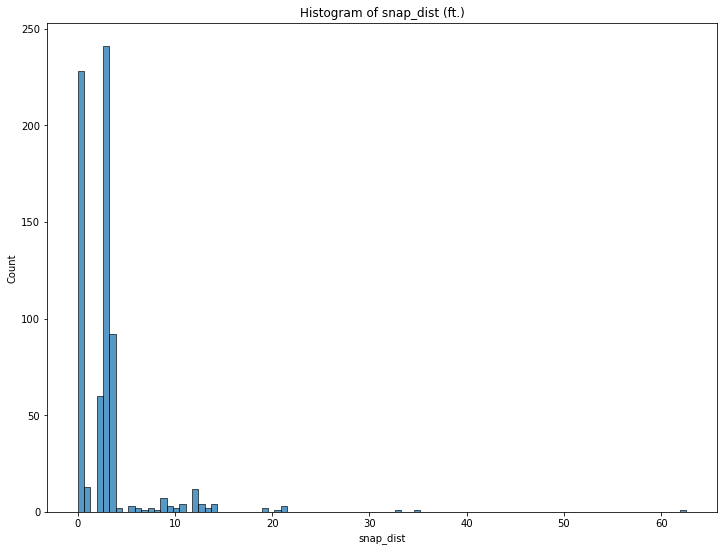

In [546]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [547]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
6           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
12          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
20          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
21          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
59          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

   boro_code  line_i physicalid             st_label         st_name  \
6          4   613.0     172255            BCH 79 ST            B 79   
12         4   613.0     172255            BCH 79 ST            B 79   
20         4   358.0     168842            BCH 69 ST            B 69   
21         4   167.0      14072  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH   
59         4   446.0      14345            BCH 59 ST            B 59   

            full_stree rw_type rw_type_name st_width frm_lvl_co  
6              B 79 ST       1       Street       25         13  
12             B 79 ST       1       Street       25         13  
20             B 69 ST       1       Street       45         13  
21  ROCKAWAY BEACH AVE       1       Street       53         13  
59             B 59 ST       1       Street       50         13

In [548]:
updated_points.physicalid.value_counts()

89897     48
168518    22
92055     22
14104     20
14030     17
          ..
14630      1
90905      1
78832      1
168701     1
117451     1
Name: physicalid, Length: 205, dtype: int64

In [549]:
updated_points.loc[updated_points.physicalid == '89897'].iloc[:, 30:45].head()

index_right ntacode county_fips                   ntaname boro_name  \
929           131    QN12         081  Hammels-Arverne-Edgemere    Queens   
1016          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
1712          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
2815          131    QN12         081  Hammels-Arverne-Edgemere    Queens   
2924          131    QN12         081  Hammels-Arverne-Edgemere    Queens   

     boro_code  line_i physicalid   st_label st_name full_stree rw_type  \
929          4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
1016         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
1712         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
2815         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   
2924         4    12.0      89897  BCH 84 ST    B 84    B 84 ST       1   

     rw_type_name st_width frm_lvl_co  
929        Street       20         13  
1016       Street       20         13  
1712       Street       20         13  
2815       Street       20         13  
2924       Street       20         13

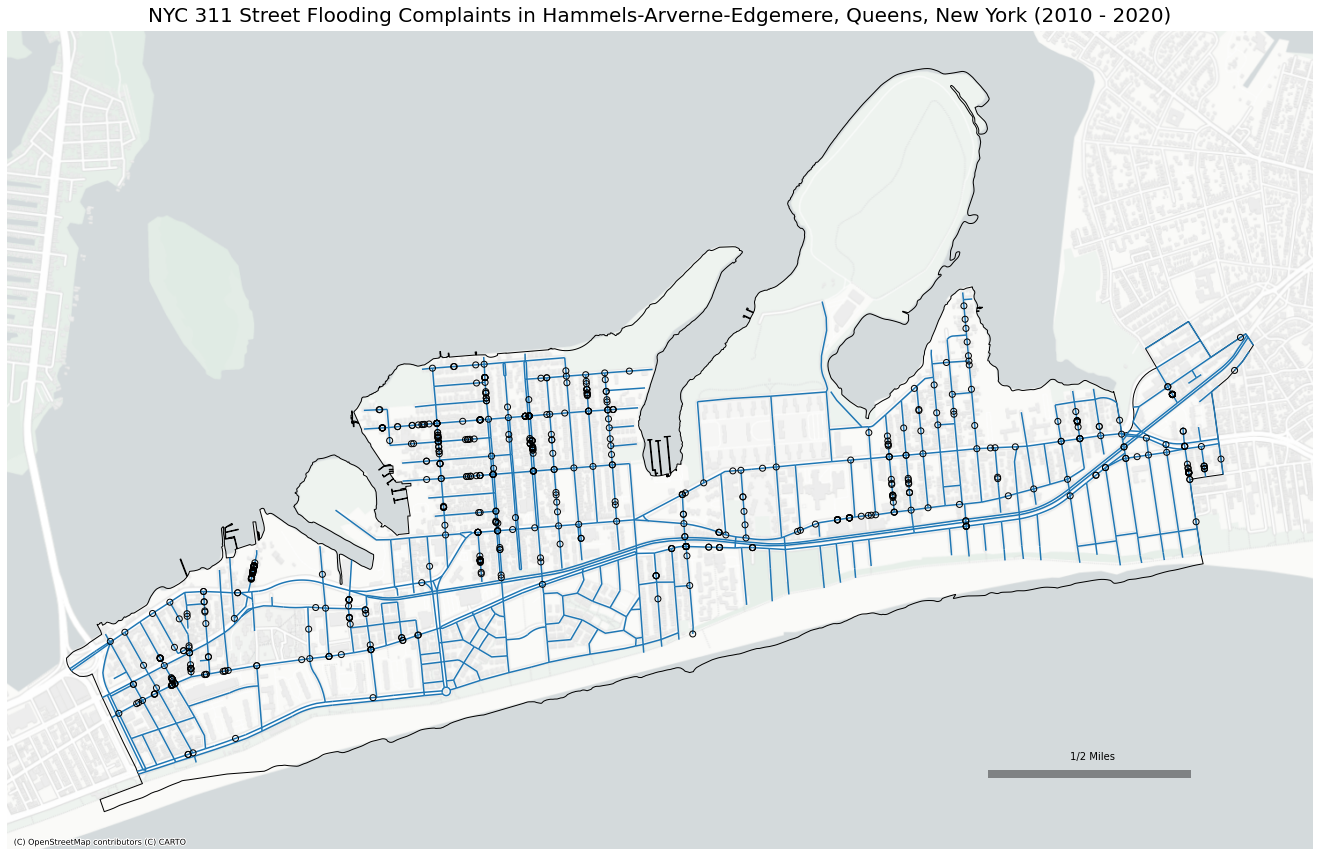

In [550]:
fig, ax = plt.subplots(figsize=(20,12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints in Hammels-Arverne-Edgemere, Queens, New York (2010 - 2020)', 
             fontsize=20,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [551]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [552]:
gdf_count.head()

physicalid  created_date
0     101236             2
1     102480             1
2     104183            12
3     104184             4
4     104185             1

In [553]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [554]:
gdf_count.head()

physicalid  count
0     101236      2
1     102480      1
2     104183     12
3     104184      4
4     104185      1

In [555]:
streets_clipped.set_geometry('geometry', inplace=True)

In [556]:
streets_clipped.geom_type.value_counts()

LineString    843
dtype: int64

In [557]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [558]:
streets_clipped.head()

physicalid             st_label         st_name          full_stree  \
41        92035            BCH 66 ST            B 66             B 66 ST   
252       14294            BCH 74 ST            B 74             B 74 ST   
347       14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
506      154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE   
1016      92062            BCH 87 ST            B 87             B 87 ST   

     rw_type rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
41         1       Street       42         13        13        4  495.233090   
252        1       Street       30         13        13        4  623.015421   
347        1       Street       35         13        13        4  234.071915   
506        1       Street       31         13        13        4  255.930554   
1016       1       Street       24         13        13        4  186.284190   

                                               geometry  \
41    LINESTRING (1041022.181 156864.681, 1040981.69...   
252   LINESTRING (1039173.301 154571.323, 1039121.22...   
347   LINESTRING (1046371.747 155628.532, 1046139.47...   
506   LINESTRING (1041944.905 154892.163, 1041702.46...   
1016  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                               new_geom  
41    POLYGON ((1040941.827 157354.986, 1041021.559 ...  
252   POLYGON ((1039081.367 155188.815, 1039161.087 ...  
347   POLYGON ((1046144.416 155559.902, 1046134.526 ...  
506   POLYGON ((1041715.285 154772.266, 1041689.651 ...  
1016  POLYGON ((1036368.829 153537.091, 1036448.590 ...

In [559]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 41 to 99101
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 92.2+ KB


In [560]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [561]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         205 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [562]:
streets_with_count.isna().sum()

physicalid        0
st_label          0
st_name           0
full_stree        0
rw_type           0
rw_type_name      0
st_width          0
frm_lvl_co        0
to_lvl_co         0
borocode          0
shape_leng        0
geometry          0
new_geom          0
count           638
dtype: int64

In [563]:
streets_with_count['count'].fillna(0, inplace=True)

In [564]:
streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       42         13        13        4  495.233090   
1       Street       30         13        13        4  623.015421   
2       Street       35         13        13        4  234.071915   
3       Street       31         13        13        4  255.930554   
4       Street       24         13        13        4  186.284190   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0

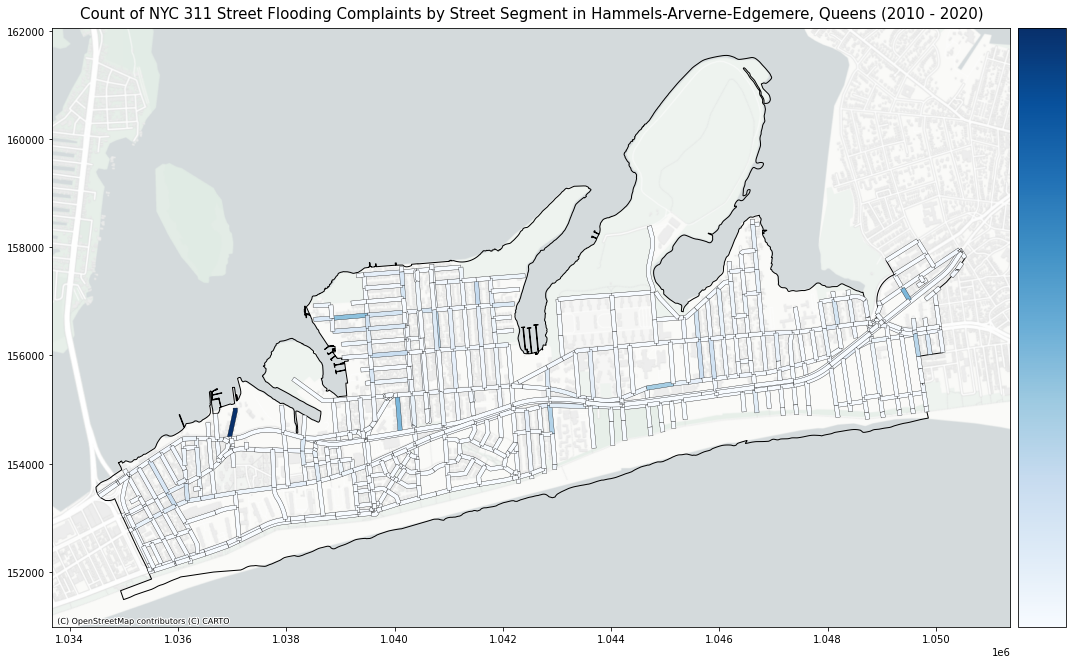

In [565]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

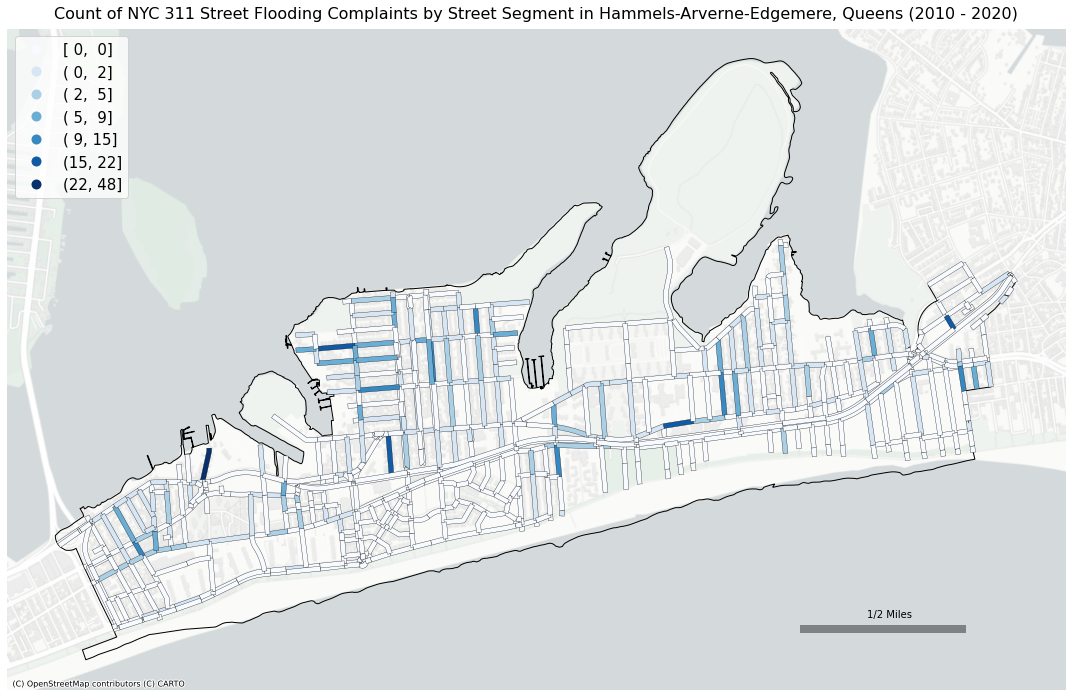

In [566]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                            'fmt': "{:,.0f}",
                                            'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=16,
             pad=10)

plt.axis('off')
plt.tight_layout()

In [567]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 843 entries, 0 to 842
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    843 non-null    object  
 1   st_label      843 non-null    object  
 2   st_name       843 non-null    object  
 3   full_stree    843 non-null    object  
 4   rw_type       843 non-null    object  
 5   rw_type_name  843 non-null    object  
 6   st_width      843 non-null    object  
 7   frm_lvl_co    843 non-null    object  
 8   to_lvl_co     843 non-null    object  
 9   borocode      843 non-null    object  
 10  shape_leng    843 non-null    float64 
 11  geometry      843 non-null    geometry
 12  new_geom      843 non-null    geometry
 13  count         843 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 98.8+ KB


In [568]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [569]:
streets_with_count.length.describe()

count     843.000000
mean      765.465404
std       480.935941
min       160.000025
25%       431.234423
50%       662.259194
75%       951.824937
max      4017.618319
dtype: float64

In [570]:
streets_with_count.describe()

shape_leng       count
count   843.000000  843.000000
mean    765.465404    0.820878
std     480.935941    2.776289
min     160.000025    0.000000
25%     431.234423    0.000000
50%     662.259194    0.000000
75%     951.824937    0.000000
max    4017.618319   48.000000

In [571]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid             st_label         st_name          full_stree rw_type  \
0      92035            BCH 66 ST            B 66             B 66 ST       1   
1      14294            BCH 74 ST            B 74             B 74 ST       1   
2      14034  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
3     154483  ROCKAWAY BEACH BLVD  ROCKAWAY BEACH  ROCKAWAY BEACH AVE       1   
4      92062            BCH 87 ST            B 87             B 87 ST       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       Street       42         13        13        4  1150.466181   
1       Street       30         13        13        4  1406.030841   
2       Street       35         13        13        4   628.143830   
3       Street       31         13        13        4   671.861108   
4       Street       24         13        13        4   532.568379   

                                            geometry  \
0  LINESTRING (1041022.181 156864.681, 1040981.69...   
1  LINESTRING (1039173.301 154571.323, 1039121.22...   
2  LINESTRING (1046371.747 155628.532, 1046139.47...   
3  LINESTRING (1041944.905 154892.163, 1041702.46...   
4  LINESTRING (1036423.096 153354.452, 1036408.71...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((1040941.827 157354.986, 1041021.559 ...    1.0         0.086921  
1  POLYGON ((1039081.367 155188.815, 1039161.087 ...    0.0         0.000000  
2  POLYGON ((1046144.416 155559.902, 1046134.526 ...    0.0         0.000000  
3  POLYGON ((1041715.285 154772.266, 1041689.651 ...    0.0         0.000000  
4  POLYGON ((1036368.829 153537.091, 1036448.590 ...    0.0         0.000000

In [572]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   843.000000  843.000000       843.000000
mean    765.465404    0.820878         0.106457
std     480.935941    2.776289         0.347350
min     160.000025    0.000000         0.000000
25%     431.234423    0.000000         0.000000
50%     662.259194    0.000000         0.000000
75%     951.824937    0.000000         0.000000
max    4017.618319   48.000000         4.644650

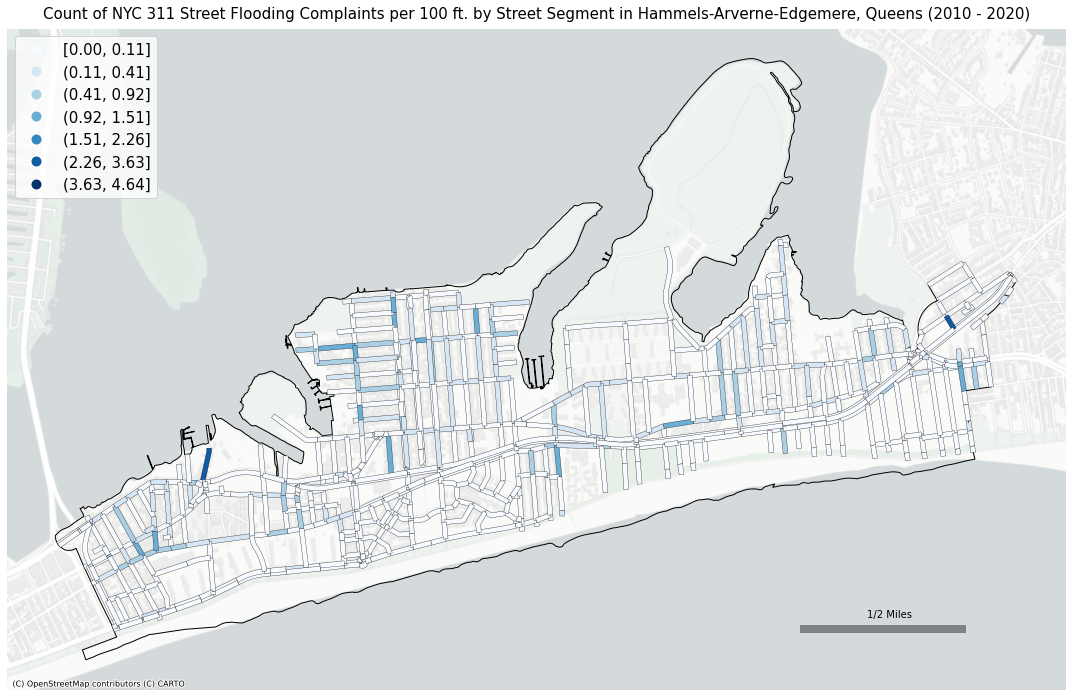

In [573]:
fig, ax = plt.subplots(figsize=(15,15)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'Hammels-Arverne-Edgemere'].plot(ax=ax, 
                                                                zorder=1, 
                                                                color='None', 
                                                                edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [1047000, 1047000+5280/2], [152000, 152000]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, 
         zorder=3)

# adding the scale bar text to the line
plt.text(1047000 + (5280/2/2.5), 152000 + 200, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft. by Street Segment in Hammels-Arverne-Edgemere, Queens (2010 - 2020)', 
             fontsize=15,
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/pres-13.png')

<AxesSubplot:>

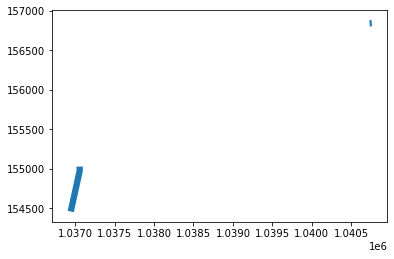

In [574]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [575]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid     st_label  st_name   full_stree rw_type rw_type_name  \
141      14099   ALMEDA AVE   ALMEDA   ALMEDA AVE       1       Street   
12       89897    BCH 84 ST     B 84      B 84 ST       1       Street   
721     168518    BCH 32 ST     B 32      B 32 ST       1       Street   
289      14115  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   
294      14110  THURSBY AVE  THURSBY  THURSBY AVE       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
141       52         13        13        4   215.301494   
12        20         13        13        4  1322.346934   
721       30         13        13        4   670.276012   
289       60         13        13        4   216.157649   
294       58         13        13        4   221.032906   

                                              geometry  \
141  LINESTRING (1040758.199 156843.323, 1040743.30...   
12   LINESTRING (1036945.986 154458.262, 1037059.20...   
721  LINESTRING (1049512.805 157017.705, 1049383.00...   
289  LINESTRING (1040269.040 156052.196, 1040255.64...   
294  LINESTRING (1040815.925 156097.308, 1040800.88...   

                                              new_geom  count  count_per_100ft  
141  POLYGON ((1040746.527 156802.249, 1040746.464 ...   10.0         4.644650  
12   POLYGON ((1037019.120 154979.182, 1037018.204 ...   48.0         3.629910  
721  POLYGON ((1049348.570 157217.010, 1049417.444 ...   22.0         3.282230  
289  POLYGON ((1040258.352 156011.379, 1040258.188 ...    7.0         3.238377  
294  POLYGON ((1040804.822 156056.256, 1040790.137 ...    5.0         2.262107

In [576]:
streets_with_count['count'].sum()

692.0

## New Dorp - Midland Beach, Staten Island

In [577]:
gdf = gpd.GeoDataFrame(flooding_311, 
                       geometry=gpd.points_from_xy(flooding_311.x_coordinate_state_plane, 
                                                   flooding_311.y_coordinate_state_plane))

In [578]:
gdf.head()

unique_key             created_date              closed_date agency  \
0    31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
1    25163797  2013-03-12T12:38:00.000  2013-03-12T14:20:00.000    DEP   
2    25185984  2013-03-15T12:13:00.000  2013-03-18T14:15:00.000    DEP   
3    25187738  2013-03-15T12:20:00.000  2013-03-15T14:22:00.000    DEP   
4    25338491  2013-04-11T12:16:00.000  2013-04-11T12:16:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11694.0                   NaN   
1  Street Flooding (SJ)       11236.0                   NaN   
2  Street Flooding (SJ)       11236.0                   NaN   
3  Street Flooding (SJ)       11236.0                   NaN   
4  Street Flooding (SJ)       11236.0                   NaN   

  intersection_street_2  ... park_borough   latitude  longitude  \
0                   NaN  ...       QUEENS  40.584819 -73.822517   
1                   NaN  ...     BROOKLYN        NaN        NaN   
2                   NaN  ...     BROOKLYN        NaN        NaN   
3                   NaN  ...     BROOKLYN        NaN        NaN   
4                   NaN  ...     BROOKLYN        NaN        NaN   

                                            location  incident_address  \
0  {'latitude': '40.5848189', 'longitude': '-73.8...  BEACH 101 STREET   
1                                                NaN       CHURCH LANE   
2                                                NaN       CHURCH LANE   
3                                                NaN       CHURCH LANE   
4                                                NaN       CHURCH LANE   

        street_name    cross_street_1       cross_street_2  bbl  \
0  BEACH 101 STREET  ROCKAWAY FREEWAY  BEACH CHANNEL DRIVE  NaN   
1       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
2       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
3       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   
4       CHURCH LANE    EAST 89 STREET       EAST 88 STREET  NaN   

                         geometry  
0  POINT (1033547.000 152391.000)  
1  POINT (1010685.000 171510.000)  
2  POINT (1010685.000 171510.000)  
3  POINT (1010685.000 171510.000)  
4  POINT (1010685.000 171510.000)  

[5 rows x 31 columns]

In [579]:
gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

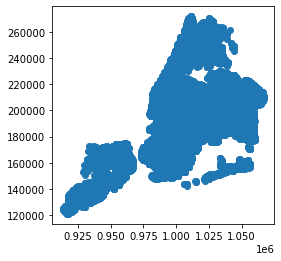

In [580]:
gdf.plot()

In [581]:
gdf.shape

(26925, 31)

In [582]:
gdf.isna().sum()

unique_key                            0
created_date                          0
closed_date                           2
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
incident_zip                          0
intersection_street_1             17577
intersection_street_2             17577
address_type                          0
city                                  0
status                                0
resolution_description                7
resolution_action_updated_date        0
community_board                       0
borough                               0
x_coordinate_state_plane              0
y_coordinate_state_plane              0
open_data_channel_type                0
park_facility_name                    0
park_borough                          0
latitude                           2499
longitude                          2499
location                           2499


In [583]:
gdf = gpd.sjoin(gdf, 
                nta_shape, 
                how="inner", 
                op='within')

In [584]:
gdf.head()

unique_key             created_date              closed_date agency  \
0      31862075  2015-10-28T17:44:00.000  2015-10-29T11:30:00.000    DEP   
352    48315004  2020-12-03T11:59:00.000  2020-12-04T10:45:00.000    DEP   
379    48257821  2020-11-26T17:09:00.000  2020-12-08T15:25:00.000    DEP   
424    48351959  2020-12-07T09:26:00.000  2020-12-15T17:30:00.000    DEP   
698    47194494  2020-08-10T14:49:00.000  2020-08-11T11:50:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
352  Department of Environmental Protection          Sewer   
379  Department of Environmental Protection          Sewer   
424  Department of Environmental Protection          Sewer   
698  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)       11694.0                   NaN   
352  Street Flooding (SJ)       11694.0                   NaN   
379  Street Flooding (SJ)       11694.0                   NaN   
424  Street Flooding (SJ)       11694.0                   NaN   
698  Street Flooding (SJ)       11694.0                   NaN   

    intersection_street_2  ...           bbl                        geometry  \
0                     NaN  ...           NaN  POINT (1033547.000 152391.000)   
352                   NaN  ...  4.163140e+09  POINT (1021913.000 146937.000)   
379                   NaN  ...  4.162250e+09  POINT (1026335.000 149464.000)   
424                   NaN  ...  4.161660e+09  POINT (1029969.000 151595.000)   
698                   NaN  ...  4.162380e+09  POINT (1026572.000 148945.000)   

    index_right ntacode     shape_area county_fips  \
0           182    QN10  100209724.039         081   
352         182    QN10  100209724.039         081   
379         182    QN10  100209724.039         081   
424         182    QN10  100209724.039         081   
698         182    QN10  100209724.039         081   

                                               ntaname     shape_leng  \
0    Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
352  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
379  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
424  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   
698  Breezy Point-Belle Harbor-Rockaway Park-Broad ...  119016.703209   

     boro_name boro_code  
0       Queens         4  
352     Queens         4  
379     Queens         4  
424     Queens         4  
698     Queens         4  

[5 rows x 39 columns]

In [585]:
gdf.drop(columns=["shape_leng", 'shape_area'], inplace=True)

In [586]:
ls data-raw/

raw-street-flooding-data.csv  raw-streets-clipped.json


In [587]:
path = 'data-raw/raw-streets-clipped.json'
streets = gpd.read_file(path)

streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [588]:
streets.shape

(99362, 12)

<AxesSubplot:>

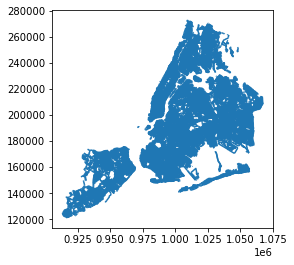

In [589]:
streets.plot()

In [590]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 99362 entries, 0 to 99361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    99362 non-null  object  
 1   st_label      99362 non-null  object  
 2   st_name       99362 non-null  object  
 3   full_stree    99362 non-null  object  
 4   rw_type       99362 non-null  object  
 5   rw_type_name  99362 non-null  object  
 6   st_width      99362 non-null  object  
 7   frm_lvl_co    99362 non-null  object  
 8   to_lvl_co     99362 non-null  object  
 9   borocode      99362 non-null  object  
 10  shape_leng    99362 non-null  float64 
 11  geometry      99362 non-null  geometry
dtypes: float64(1), geometry(1), object(10)
memory usage: 9.1+ MB


In [591]:
streets.describe()

shape_leng
count  9.936200e+04
mean   3.431188e+02
std    2.620211e+02
min    1.068681e-08
25%    1.953735e+02
50%    2.648459e+02
75%    4.583545e+02
max    1.509366e+04

In [592]:
streets.geom_type.value_counts()

LineString    99362
dtype: int64

In [593]:
streets.head()

physicalid         st_label       st_name       full_stree rw_type  \
0       6110           28 AVE            28           28 AVE       1   
1      61140    ARLINGTON AVE     ARLINGTON    ARLINGTON AVE       1   
2     145494  SCHERMERHORN ST  SCHERMERHORN  SCHERMERHORN ST       1   
3      12438      QUEENS BLVD        QUEENS      QUEENS BLVD       1   
4      15432   ARTHUR KILL RD    ARTHUR KIL    ARTHUR KIL RD       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       35         13        13        4  258.859740   
1       Street       42         13        13        2  454.932922   
2       Street       50         13        13        3  609.424375   
3       Street       40         13        13        4   47.399228   
4       Street       36         13        13        5  268.228751   

                                            geometry  
0  LINESTRING (1047146.080 222733.432, 1047385.93...  
1  LINESTRING (1009926.638 269075.549, 1010033.71...  
2  LINESTRING (989292.818 189689.736, 989648.842 ...  
3  LINESTRING (1031371.427 199453.863, 1031412.58...  
4  LINESTRING (940277.458 144141.538, 940027.193 ...

In [594]:
New_Dorp_Midland_Beach = nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach']

New_Dorp_Midland_Beach.head()

ntacode     shape_area county_fips                 ntaname     shape_leng  \
95    SI45  55429451.2194         085  New Dorp-Midland Beach  34336.5206382   

        boro_name boro_code                                           geometry  
95  Staten Island         5  MULTIPOLYGON (((960721.609 147492.642, 960370....

In [595]:
# clipping the school points that only fall within the nta shapes
streets_clipped = gpd.clip(streets, New_Dorp_Midland_Beach)

<AxesSubplot:>

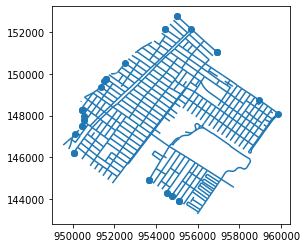

In [596]:
streets_clipped.plot()

In [597]:
streets_clipped.geom_type.value_counts()

LineString            737
Point                  32
GeometryCollection      5
MultiLineString         2
dtype: int64

In [598]:
streets_clipped = streets_clipped[streets_clipped.geom_type == 'LineString']

streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [599]:
# clipping the school points that only fall within the nta shapes
New_Dorp_Midland_Beach = gpd.clip(gdf, New_Dorp_Midland_Beach)

<AxesSubplot:>

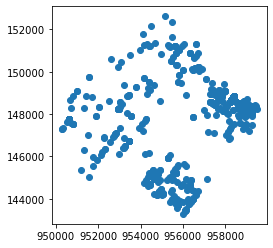

In [600]:
New_Dorp_Midland_Beach.plot()

In [601]:
New_Dorp_Midland_Beach.geom_type.value_counts()

Point    763
dtype: int64

# Snap points to lines

# https://medium.com/@brendan_ward/how-to-leverage-geopandas-for-faster-snapping-of-points-to-lines-6113c94e59aa

In [602]:
streets_clipped.sindex

rtree.index.Index(bounds=[949549.8247149212, 143281.59894616972, 959897.8481633187, 152760.96722404534], size=737)

In [603]:
offset = 80

bbox = New_Dorp_Midland_Beach.bounds + [-offset, -offset, offset, offset]

bbox.head()

minx      miny      maxx      maxy
56   958400.0  148535.0  958560.0  148695.0
107  959008.0  147996.0  959168.0  148156.0
120  957715.0  148768.0  957875.0  148928.0
121  958891.0  147414.0  959051.0  147574.0
130  957979.0  147947.0  958139.0  148107.0

In [604]:
hits = bbox.apply(lambda row: list(streets_clipped.sindex.intersection(row)), axis=1)

hits.head()

56     [474, 473, 592, 341]
107     [118, 41, 539, 573]
120    [233, 319, 516, 574]
121    [390, 117, 607, 350]
130    [365, 360, 433, 342]
dtype: object

In [605]:
hits.shape

(763,)

In [606]:
tmp = pd.DataFrame(
    # index of points table
    {"pt_idx": np.repeat(hits.index, hits.apply(len)),
        
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
    })

In [607]:
tmp.head()

pt_idx  line_i
0      56   474.0
1      56   473.0
2      56   592.0
3      56   341.0
4     107   118.0

In [608]:
tmp.shape

(2651, 2)

In [609]:
streets_clipped.shape

(737, 12)

In [610]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
90       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
411      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
551      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
581     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
651      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
90        Street       30         13        13        5  256.539897   
411       Street       30         13        13        5  447.066950   
551       Street       20         13        13        5   40.275747   
581       Street       18         13        13        5  176.145848   
651       Street       30         13        13        5  261.169357   

                                              geometry  
90   LINESTRING (954781.156 151271.724, 954597.833 ...  
411  LINESTRING (952841.921 150886.337, 953221.730 ...  
551  LINESTRING (957558.853 149344.789, 957591.137 ...  
581  LINESTRING (955726.813 147175.642, 955875.554 ...  
651  LINESTRING (953360.096 149917.140, 953173.390 ...

In [611]:
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(streets_clipped.reset_index(drop=True), on="line_i")

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0      56   474.0      53942   FREEBORN ST  FREEBORN   FREEBORN ST       1   
1      56   473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
2      56   592.0      76094  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
3      56   341.0      53943   FREEBORN ST  FREEBORN   FREEBORN ST       1   
4     107   118.0      85564      BADEN PL     BADEN      BADEN PL       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       30         13        13        5  419.460686   
1       Street       25         13        13        5  248.849478   
2       Street       18         13        13        5  251.356512   
3       Street       30         13        13        5  367.426528   
4       Street       32         13        13        5  454.064519   

                                            geometry  
0  LINESTRING (958524.695 148581.558, 958279.269 ...  
1  LINESTRING (958524.695 148581.558, 958726.633 ...  
2  LINESTRING (958315.338 148720.663, 958524.695 ...  
3  LINESTRING (958741.797 148877.985, 958524.695 ...  
4  LINESTRING (959135.084 148145.979, 958868.434 ...

In [612]:
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(New_Dorp_Midland_Beach.geometry.rename("point"), on="pt_idx")

# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=New_Dorp_Midland_Beach.crs)

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
0      56   474.0      53942   FREEBORN ST  FREEBORN   FREEBORN ST       1   
1      56   473.0      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
2      56   592.0      76094  MAPLETON AVE  MAPLETON  MAPLETON AVE       1   
3      56   341.0      53943   FREEBORN ST  FREEBORN   FREEBORN ST       1   
4     107   118.0      85564      BADEN PL     BADEN      BADEN PL       1   

  rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       Street       30         13        13        5  419.460686   
1       Street       25         13        13        5  248.849478   
2       Street       18         13        13        5  251.356512   
3       Street       30         13        13        5  367.426528   
4       Street       32         13        13        5  454.064519   

                                            geometry  \
0  LINESTRING (958524.695 148581.558, 958279.269 ...   
1  LINESTRING (958524.695 148581.558, 958726.633 ...   
2  LINESTRING (958315.338 148720.663, 958524.695 ...   
3  LINESTRING (958741.797 148877.985, 958524.695 ...   
4  LINESTRING (959135.084 148145.979, 958868.434 ...   

                           point  
0  POINT (958480.000 148615.000)  
1  POINT (958480.000 148615.000)  
2  POINT (958480.000 148615.000)  
3  POINT (958480.000 148615.000)  
4  POINT (959088.000 148076.000)

In [613]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

tmp[['snap_dist']].describe()

snap_dist
count  2651.000000
mean     79.239112
std     111.270599
min       0.000567
25%       0.489088
50%      24.095470
75%      97.963148
max    1119.662091

In [614]:
# Discard any lines that are greater than tolerance from points
tmp = tmp.loc[tmp.snap_dist <= offset]

# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

tmp.head()

pt_idx  line_i physicalid      st_label   st_name    full_stree rw_type  \
2542   27215   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
1757   19670   292.0      55540  BANCROFT AVE  BANCROFT  BANCROFT AVE       1   
1163   10270   497.0      64050    CLAWSON ST   CLAWSON    CLAWSON ST       1   
2449   26876   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   
2510   27126   668.0      15665    HYLAN BLVD     HYLAN    HYLAN BLVD       1   

     rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
2542       Street       30         13        13        5  608.866647   
1757       Street       30         13        13        5  608.866647   
1163       Street       32         13        13        5  259.287109   
2449       Street       70         13        13        5  305.775123   
2510       Street       70         13        13        5  305.775123   

                                               geometry  \
2542  LINESTRING (953291.900 149648.075, 953790.042 ...   
1757  LINESTRING (953291.900 149648.075, 953790.042 ...   
1163  LINESTRING (952706.317 146911.440, 952557.581 ...   
2449  LINESTRING (956007.528 150101.076, 955827.781 ...   
2510  LINESTRING (956007.528 150101.076, 955827.781 ...   

                              point  snap_dist  
2542  POINT (953790.000 149298.000)   0.000567  
1757  POINT (953790.000 149298.000)   0.000567  
1163  POINT (952706.000 146911.000)   0.007325  
2449  POINT (955828.000 149854.000)   0.007674  
2510  POINT (955828.000 149854.000)   0.007674

In [615]:
tmp[['snap_dist']].describe()

snap_dist
count  1648.000000
mean     13.755014
std      23.876935
min       0.000567
25%       0.375526
50%       2.640262
75%       4.028307
max      79.689427

In [616]:
# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()

# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")

closest.head()

line_i physicalid       st_label    st_name     full_stree rw_type  \
pt_idx                                                                       
56       592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE       1   
107      118.0      85564       BADEN PL      BADEN       BADEN PL       1   
120      574.0      52067     KISWICK ST    KISWICK     KISWICK ST       1   
121      350.0      85558  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
130      433.0      52316    MIDLAND AVE    MIDLAND    MIDLAND AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
56           Street       18         13        13        5  251.356512   
107          Street       32         13        13        5  454.064519   
120          Street       38         13        13        5  549.294789   
121          Street       32         13        13        5  270.547038   
130          Street       54         13        13        5  249.088967   

                                                 geometry  \
pt_idx                                                      
56      LINESTRING (958315.338 148720.663, 958524.695 ...   
107     LINESTRING (959135.084 148145.979, 958868.434 ...   
120     LINESTRING (958113.203 149295.665, 957794.955 ...   
121     LINESTRING (959078.132 147636.501, 958920.248 ...   
130     LINESTRING (957901.769 148144.469, 958104.144 ...   

                                point  snap_dist  
pt_idx                                            
56      POINT (958480.000 148615.000)   3.119078  
107     POINT (959088.000 148076.000)   2.985110  
120     POINT (957795.000 148848.000)   0.010657  
121     POINT (958971.000 147494.000)   3.838005  
130     POINT (958059.000 148027.000)   3.771349

In [617]:
# Position of nearest point from start of the line
pos = closest.geometry.project(gpd.GeoSeries(closest.point))

# Get new point location geometry
new_pts = closest.geometry.interpolate(pos)

new_pts.head()

pt_idx
56     POINT (958478.274 148612.402)
107    POINT (959085.584 148077.753)
120    POINT (957794.991 148848.006)
121    POINT (958974.117 147491.760)
130    POINT (958061.199 148030.064)
dtype: geometry

In [618]:
# Create a new GeoDataFrame from the columns from the closest line and new point geometries (which will be called "geometries")
snapped = gpd.GeoDataFrame(closest, geometry=new_pts)

snapped.head()

line_i physicalid       st_label    st_name     full_stree rw_type  \
pt_idx                                                                       
56       592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE       1   
107      118.0      85564       BADEN PL      BADEN       BADEN PL       1   
120      574.0      52067     KISWICK ST    KISWICK     KISWICK ST       1   
121      350.0      85558  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
130      433.0      52316    MIDLAND AVE    MIDLAND    MIDLAND AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
56           Street       18         13        13        5  251.356512   
107          Street       32         13        13        5  454.064519   
120          Street       38         13        13        5  549.294789   
121          Street       32         13        13        5  270.547038   
130          Street       54         13        13        5  249.088967   

                             geometry                          point  \
pt_idx                                                                 
56      POINT (958478.274 148612.402)  POINT (958480.000 148615.000)   
107     POINT (959085.584 148077.753)  POINT (959088.000 148076.000)   
120     POINT (957794.991 148848.006)  POINT (957795.000 148848.000)   
121     POINT (958974.117 147491.760)  POINT (958971.000 147494.000)   
130     POINT (958061.199 148030.064)  POINT (958059.000 148027.000)   

        snap_dist  
pt_idx             
56       3.119078  
107      2.985110  
120      0.010657  
121      3.838005  
130      3.771349

In [619]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
56     38405602  2018-02-06T16:17:00.000  2018-02-08T10:38:00.000    DEP   
107    39982290  2018-08-11T09:25:00.000  2018-08-11T11:55:00.000    DEP   
120    40325958  2018-09-19T07:35:00.000  2018-09-20T09:30:00.000    DEP   
121    40373488  2018-09-25T20:51:00.000  2018-09-28T10:30:00.000    DEP   
130    40392623  2018-09-27T13:42:00.000  2018-09-28T10:30:00.000    DEP   

                                agency_name complaint_type  \
56   Department of Environmental Protection          Sewer   
107  Department of Environmental Protection          Sewer   
120  Department of Environmental Protection          Sewer   
121  Department of Environmental Protection          Sewer   
130  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
56   Street Flooding (SJ)       10306.0                   NaN   
107  Street Flooding (SJ)       10306.0                   NaN   
120  Street Flooding (SJ)       10306.0        KISWICK STREET   
121  Street Flooding (SJ)       10306.0                   NaN   
130  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... cross_street_1 cross_street_2           bbl  \
56                    NaN  ...     GRIMSBY ST    FREEBORN ST  5.037960e+09   
107                   NaN  ...   MAPLETON AVE  HEMPSTEAD AVE  5.038100e+09   
120        BEDFORD AVENUE  ...            NaN            NaN           NaN   
121                   NaN  ...  HEMPSTEAD AVE    MIDLAND AVE  5.038130e+09   
130                   NaN  ...     GRIMSBY ST    FREEBORN ST  5.038030e+09   

                          geometry index_right ntacode county_fips  \
56   POINT (958480.000 148615.000)          95    SI45         085   
107  POINT (959088.000 148076.000)          95    SI45         085   
120  POINT (957795.000 148848.000)          95    SI45         085   
121  POINT (958971.000 147494.000)          95    SI45         085   
130  POINT (958059.000 148027.000)          95    SI45         085   

                    ntaname      boro_name boro_code  
56   New Dorp-Midland Beach  Staten Island         5  
107  New Dorp-Midland Beach  Staten Island         5  
120  New Dorp-Midland Beach  Staten Island         5  
121  New Dorp-Midland Beach  Staten Island         5  
130  New Dorp-Midland Beach  Staten Island         5  

[5 rows x 37 columns]

In [620]:
New_Dorp_Midland_Beach.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 763 entries, 56 to 27857
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   unique_key                      763 non-null    int64   
 1   created_date                    763 non-null    object  
 2   closed_date                     763 non-null    object  
 3   agency                          763 non-null    object  
 4   agency_name                     763 non-null    object  
 5   complaint_type                  763 non-null    object  
 6   descriptor                      763 non-null    object  
 7   incident_zip                    763 non-null    float64 
 8   intersection_street_1           216 non-null    object  
 9   intersection_street_2           216 non-null    object  
 10  address_type                    763 non-null    object  
 11  city                            763 non-null    object  
 12  status     

In [621]:
New_Dorp_Midland_Beach.drop(columns=["geometry"], inplace=True)

In [622]:
New_Dorp_Midland_Beach.head()

unique_key             created_date              closed_date agency  \
56     38405602  2018-02-06T16:17:00.000  2018-02-08T10:38:00.000    DEP   
107    39982290  2018-08-11T09:25:00.000  2018-08-11T11:55:00.000    DEP   
120    40325958  2018-09-19T07:35:00.000  2018-09-20T09:30:00.000    DEP   
121    40373488  2018-09-25T20:51:00.000  2018-09-28T10:30:00.000    DEP   
130    40392623  2018-09-27T13:42:00.000  2018-09-28T10:30:00.000    DEP   

                                agency_name complaint_type  \
56   Department of Environmental Protection          Sewer   
107  Department of Environmental Protection          Sewer   
120  Department of Environmental Protection          Sewer   
121  Department of Environmental Protection          Sewer   
130  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
56   Street Flooding (SJ)       10306.0                   NaN   
107  Street Flooding (SJ)       10306.0                   NaN   
120  Street Flooding (SJ)       10306.0        KISWICK STREET   
121  Street Flooding (SJ)       10306.0                   NaN   
130  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ...      street_name cross_street_1 cross_street_2  \
56                    NaN  ...  MAPLETON AVENUE     GRIMSBY ST    FREEBORN ST   
107                   NaN  ...      BADEN PLACE   MAPLETON AVE  HEMPSTEAD AVE   
120        BEDFORD AVENUE  ...              NaN            NaN            NaN   
121                   NaN  ...    PATTERSON AVE  HEMPSTEAD AVE    MIDLAND AVE   
130                   NaN  ...      MIDLAND AVE     GRIMSBY ST    FREEBORN ST   

              bbl index_right ntacode county_fips                 ntaname  \
56   5.037960e+09          95    SI45         085  New Dorp-Midland Beach   
107  5.038100e+09          95    SI45         085  New Dorp-Midland Beach   
120           NaN          95    SI45         085  New Dorp-Midland Beach   
121  5.038130e+09          95    SI45         085  New Dorp-Midland Beach   
130  5.038030e+09          95    SI45         085  New Dorp-Midland Beach   

         boro_name boro_code  
56   Staten Island         5  
107  Staten Island         5  
120  Staten Island         5  
121  Staten Island         5  
130  Staten Island         5  

[5 rows x 36 columns]

In [623]:
snapped.head()

line_i physicalid       st_label    st_name     full_stree rw_type  \
pt_idx                                                                       
56       592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE       1   
107      118.0      85564       BADEN PL      BADEN       BADEN PL       1   
120      574.0      52067     KISWICK ST    KISWICK     KISWICK ST       1   
121      350.0      85558  PATTERSON AVE  PATTERSON  PATTERSON AVE       1   
130      433.0      52316    MIDLAND AVE    MIDLAND    MIDLAND AVE       1   

       rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
pt_idx                                                                   
56           Street       18         13        13        5  251.356512   
107          Street       32         13        13        5  454.064519   
120          Street       38         13        13        5  549.294789   
121          Street       32         13        13        5  270.547038   
130          Street       54         13        13        5  249.088967   

                             geometry                          point  \
pt_idx                                                                 
56      POINT (958478.274 148612.402)  POINT (958480.000 148615.000)   
107     POINT (959085.584 148077.753)  POINT (959088.000 148076.000)   
120     POINT (957794.991 148848.006)  POINT (957795.000 148848.000)   
121     POINT (958974.117 147491.760)  POINT (958971.000 147494.000)   
130     POINT (958061.199 148030.064)  POINT (958059.000 148027.000)   

        snap_dist  
pt_idx             
56       3.119078  
107      2.985110  
120      0.010657  
121      3.838005  
130      3.771349

In [624]:
# Join back to the original points:
updated_points = New_Dorp_Midland_Beach.join(snapped)

updated_points.head()

unique_key             created_date              closed_date agency  \
56     38405602  2018-02-06T16:17:00.000  2018-02-08T10:38:00.000    DEP   
107    39982290  2018-08-11T09:25:00.000  2018-08-11T11:55:00.000    DEP   
120    40325958  2018-09-19T07:35:00.000  2018-09-20T09:30:00.000    DEP   
121    40373488  2018-09-25T20:51:00.000  2018-09-28T10:30:00.000    DEP   
130    40392623  2018-09-27T13:42:00.000  2018-09-28T10:30:00.000    DEP   

                                agency_name complaint_type  \
56   Department of Environmental Protection          Sewer   
107  Department of Environmental Protection          Sewer   
120  Department of Environmental Protection          Sewer   
121  Department of Environmental Protection          Sewer   
130  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
56   Street Flooding (SJ)       10306.0                   NaN   
107  Street Flooding (SJ)       10306.0                   NaN   
120  Street Flooding (SJ)       10306.0        KISWICK STREET   
121  Street Flooding (SJ)       10306.0                   NaN   
130  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
56                    NaN  ...       1       Street       18         13   
107                   NaN  ...       1       Street       32         13   
120        BEDFORD AVENUE  ...       1       Street       38         13   
121                   NaN  ...       1       Street       32         13   
130                   NaN  ...       1       Street       54         13   

    to_lvl_co borocode  shape_leng                       geometry  \
56         13        5  251.356512  POINT (958478.274 148612.402)   
107        13        5  454.064519  POINT (959085.584 148077.753)   
120        13        5  549.294789  POINT (957794.991 148848.006)   
121        13        5  270.547038  POINT (958974.117 147491.760)   
130        13        5  249.088967  POINT (958061.199 148030.064)   

                             point snap_dist  
56   POINT (958480.000 148615.000)  3.119078  
107  POINT (959088.000 148076.000)  2.985110  
120  POINT (957795.000 148848.000)  0.010657  
121  POINT (958971.000 147494.000)  3.838005  
130  POINT (958059.000 148027.000)  3.771349  

[5 rows x 51 columns]

In [625]:
updated_points.geometry.isna().sum()

5

In [626]:
# You may want to drop any that didn't snap, if so:
updated_points = updated_points.dropna(subset=["geometry"])

updated_points.head()

unique_key             created_date              closed_date agency  \
56     38405602  2018-02-06T16:17:00.000  2018-02-08T10:38:00.000    DEP   
107    39982290  2018-08-11T09:25:00.000  2018-08-11T11:55:00.000    DEP   
120    40325958  2018-09-19T07:35:00.000  2018-09-20T09:30:00.000    DEP   
121    40373488  2018-09-25T20:51:00.000  2018-09-28T10:30:00.000    DEP   
130    40392623  2018-09-27T13:42:00.000  2018-09-28T10:30:00.000    DEP   

                                agency_name complaint_type  \
56   Department of Environmental Protection          Sewer   
107  Department of Environmental Protection          Sewer   
120  Department of Environmental Protection          Sewer   
121  Department of Environmental Protection          Sewer   
130  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
56   Street Flooding (SJ)       10306.0                   NaN   
107  Street Flooding (SJ)       10306.0                   NaN   
120  Street Flooding (SJ)       10306.0        KISWICK STREET   
121  Street Flooding (SJ)       10306.0                   NaN   
130  Street Flooding (SJ)       10306.0                   NaN   

    intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
56                    NaN  ...       1       Street       18         13   
107                   NaN  ...       1       Street       32         13   
120        BEDFORD AVENUE  ...       1       Street       38         13   
121                   NaN  ...       1       Street       32         13   
130                   NaN  ...       1       Street       54         13   

    to_lvl_co borocode  shape_leng                       geometry  \
56         13        5  251.356512  POINT (958478.274 148612.402)   
107        13        5  454.064519  POINT (959085.584 148077.753)   
120        13        5  549.294789  POINT (957794.991 148848.006)   
121        13        5  270.547038  POINT (958974.117 147491.760)   
130        13        5  249.088967  POINT (958061.199 148030.064)   

                             point snap_dist  
56   POINT (958480.000 148615.000)  3.119078  
107  POINT (959088.000 148076.000)  2.985110  
120  POINT (957795.000 148848.000)  0.010657  
121  POINT (958971.000 147494.000)  3.838005  
130  POINT (958059.000 148027.000)  3.771349  

[5 rows x 51 columns]

In [627]:
updated_points.shape

(758, 51)

In [628]:
updated_points.sort_values(by='snap_dist').head()

unique_key             created_date              closed_date agency  \
27215    21377770  2011-09-06T16:37:00.000  2011-09-07T14:30:00.000    DEP   
19670    39258388  2018-05-22T12:53:00.000  2018-05-23T09:15:00.000    DEP   
10270    27165829  2014-01-16T07:30:00.000  2014-01-17T09:30:00.000    DEP   
27126    21125790  2011-08-28T12:02:00.000  2011-08-28T16:30:00.000    DEP   
26876    21034224  2011-08-14T05:49:00.000  2011-08-14T14:15:00.000    DEP   

                                  agency_name complaint_type  \
27215  Department of Environmental Protection          Sewer   
19670  Department of Environmental Protection          Sewer   
10270  Department of Environmental Protection          Sewer   
27126  Department of Environmental Protection          Sewer   
26876  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
27215  Street Flooding (SJ)       10306.0       BANCROFT AVENUE   
19670  Street Flooding (SJ)       10306.0         EDISON STREET   
10270  Street Flooding (SJ)       10306.0           ROSS AVENUE   
27126  Street Flooding (SJ)       10306.0        MIDLAND AVENUE   
26876  Street Flooding (SJ)       10306.0       HYLAN BOULEVARD   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
27215         EDISON STREET  ...       1       Street       30         13   
19670       BANCROFT AVENUE  ...       1       Street       30         13   
10270        CLAWSON STREET  ...       1       Street       32         13   
27126       HYLAN BOULEVARD  ...       1       Street       70         13   
26876        MIDLAND AVENUE  ...       1       Street       70         13   

      to_lvl_co borocode  shape_leng                       geometry  \
27215        13        5  608.866647  POINT (953790.000 149298.000)   
19670        13        5  608.866647  POINT (953790.000 149298.000)   
10270        13        5  259.287109  POINT (952706.006 146910.996)   
27126        13        5  305.775123  POINT (955827.994 149854.005)   
26876        13        5  305.775123  POINT (955827.994 149854.005)   

                               point snap_dist  
27215  POINT (953790.000 149298.000)  0.000567  
19670  POINT (953790.000 149298.000)  0.000567  
10270  POINT (952706.000 146911.000)  0.007325  
27126  POINT (955828.000 149854.000)  0.007674  
26876  POINT (955828.000 149854.000)  0.007674  

[5 rows x 51 columns]

In [629]:
updated_points.sort_values(by='snap_dist', ascending=False).head()

unique_key             created_date              closed_date agency  \
14900    32698429  2016-02-16T15:09:00.000  2016-02-18T09:30:00.000    DEP   
27850    22410047  2011-12-28T00:00:00.000  2011-12-28T11:30:00.000    DEP   
27778    22267856  2011-12-06T23:42:00.000  2011-12-07T09:30:00.000    DEP   
17389    36112767  2017-05-05T13:09:00.000  2017-05-05T19:30:00.000    DEP   
2880     45618020  2020-02-14T13:54:00.000  2020-02-14T17:35:00.000    DEP   

                                  agency_name complaint_type  \
14900  Department of Environmental Protection          Sewer   
27850  Department of Environmental Protection          Sewer   
27778  Department of Environmental Protection          Sewer   
17389  Department of Environmental Protection          Sewer   
2880   Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
14900  Street Flooding (SJ)       10306.0                   NaN   
27850  Street Flooding (SJ)       10306.0                   NaN   
27778  Street Flooding (SJ)       10306.0                   NaN   
17389  Street Flooding (SJ)       10306.0                   NaN   
2880   Street Flooding (SJ)       10306.0                   NaN   

      intersection_street_2  ... rw_type rw_type_name st_width frm_lvl_co  \
14900                   NaN  ...       1       Street       30         13   
27850                   NaN  ...       1       Street       26         13   
27778                   NaN  ...       1       Street       26         13   
17389                   NaN  ...       1       Street       34         13   
2880                    NaN  ...       1       Street       30         13   

      to_lvl_co borocode  shape_leng                       geometry  \
14900        13        5  172.488718  POINT (950303.664 147302.727)   
27850        13        5  415.175106  POINT (951590.059 149773.632)   
27778        13        5  415.175106  POINT (951590.059 149773.632)   
17389        13        5  877.651987  POINT (954455.655 152137.781)   
2880         13        5  380.747823  POINT (959115.406 147207.210)   

                               point  snap_dist  
14900  POINT (950345.000 147352.000)  64.315603  
27850  POINT (951564.000 149728.000)  52.548002  
27778  POINT (951564.000 149728.000)  52.548002  
17389  POINT (954484.000 152178.000)  49.203561  
2880   POINT (959133.000 147195.000)  21.415827  

[5 rows x 51 columns]

In [630]:
updated_points[['snap_dist']].describe()

snap_dist
count  758.000000
mean     2.835182
std      4.656313
min      0.000567
25%      0.471728
50%      2.820492
75%      3.256435
max     64.315603

Text(0.5, 1.0, 'Histogram of snap_dist (ft.)')

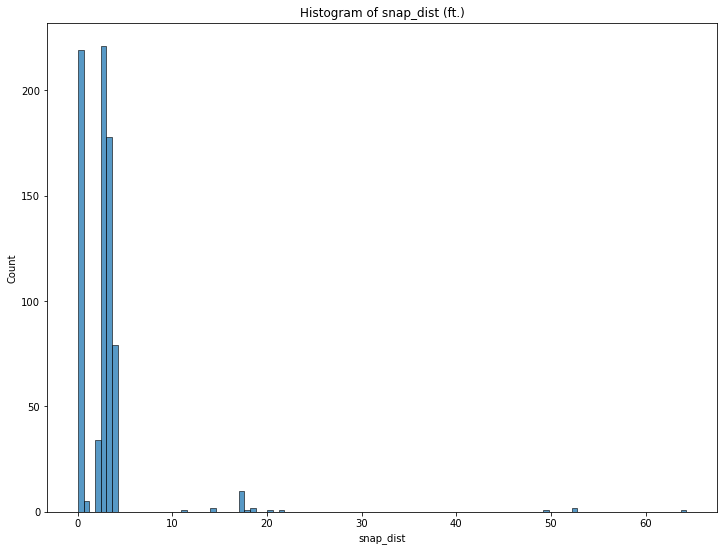

In [631]:
plt.figure(figsize=(12, 9))

sns.histplot(updated_points.snap_dist)
plt.title('Histogram of snap_dist (ft.)')

In [632]:
updated_points.iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
56            95    SI45         085  New Dorp-Midland Beach  Staten Island   
107           95    SI45         085  New Dorp-Midland Beach  Staten Island   
120           95    SI45         085  New Dorp-Midland Beach  Staten Island   
121           95    SI45         085  New Dorp-Midland Beach  Staten Island   
130           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid       st_label    st_name     full_stree  \
56          5   592.0      76094   MAPLETON AVE   MAPLETON   MAPLETON AVE   
107         5   118.0      85564       BADEN PL      BADEN       BADEN PL   
120         5   574.0      52067     KISWICK ST    KISWICK     KISWICK ST   
121         5   350.0      85558  PATTERSON AVE  PATTERSON  PATTERSON AVE   
130         5   433.0      52316    MIDLAND AVE    MIDLAND    MIDLAND AVE   

    rw_type rw_type_name st_width frm_lvl_co  
56        1       Street       18         13  
107       1       Street       32         13  
120       1       Street       38         13  
121       1       Street       32         13  
130       1       Street       54         13

In [633]:
updated_points.physicalid.value_counts()

76941     115
52067      51
63880      40
76093      31
85564      27
         ... 
173628      1
63951       1
63055       1
168356      1
98810       1
Name: physicalid, Length: 188, dtype: int64

In [634]:
updated_points.loc[updated_points.physicalid == '76941'].iloc[:, 30:45].head()

index_right ntacode county_fips                 ntaname      boro_name  \
311           95    SI45         085  New Dorp-Midland Beach  Staten Island   
314           95    SI45         085  New Dorp-Midland Beach  Staten Island   
538           95    SI45         085  New Dorp-Midland Beach  Staten Island   
772           95    SI45         085  New Dorp-Midland Beach  Staten Island   
867           95    SI45         085  New Dorp-Midland Beach  Staten Island   

    boro_code  line_i physicalid    st_label  st_name  full_stree rw_type  \
311         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
314         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
538         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
772         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   
867         5   148.0      76941  GRIMSBY ST  GRIMSBY  GRIMSBY ST       1   

    rw_type_name st_width frm_lvl_co  
311       Street       22         13  
314       Street       22         13  
538       Street       22         13  
772       Street       22         13  
867       Street       22         13

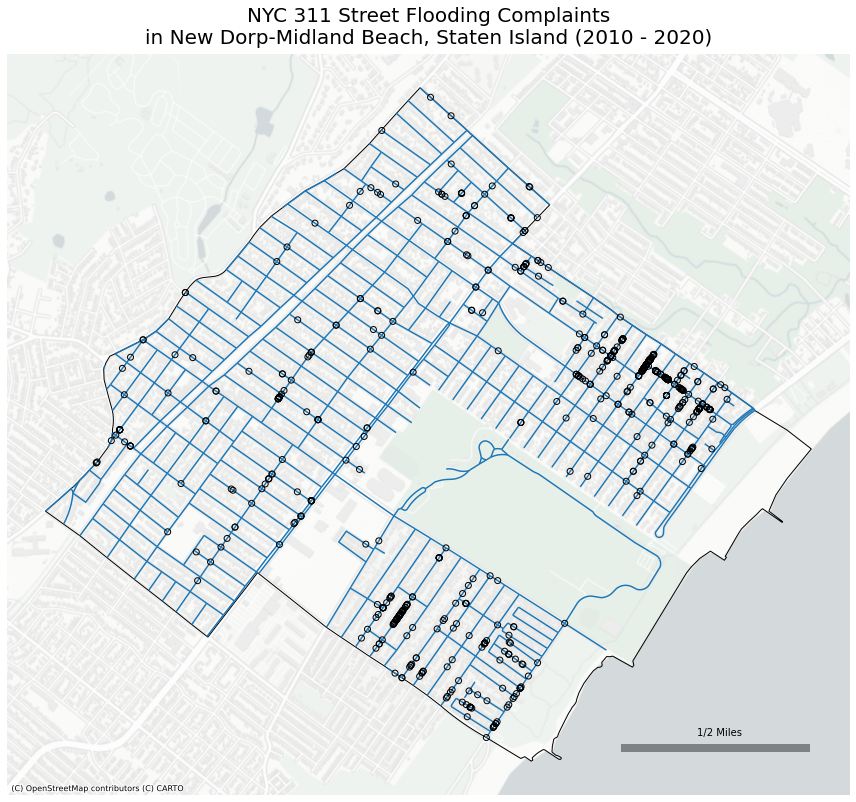

In [635]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating a figure

updated_points.plot(color='none', 
                edgecolor='black',
                ax=ax,
                zorder=3)

streets_clipped.plot(ax=ax, zorder=2)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('NYC 311 Street Flooding Complaints\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [636]:
gdf_count = updated_points.groupby(by='physicalid')['created_date'].count().reset_index()

In [637]:
gdf_count.head()

physicalid  created_date
0     100411             1
1     100451             1
2     100452             2
3     100795             1
4     100822             8

In [638]:
gdf_count.rename(columns={"created_date": "count"}, inplace=True)

In [639]:
gdf_count.head()

physicalid  count
0     100411      1
1     100451      1
2     100452      2
3     100795      1
4     100822      8

In [640]:
streets_clipped.set_geometry('geometry', inplace=True)

In [641]:
streets_clipped.geom_type.value_counts()

LineString    737
dtype: int64

In [642]:
streets_clipped['new_geom'] = streets_clipped.geometry.buffer(40, cap_style=2)

streets_clipped.set_geometry('new_geom', inplace=True)

In [643]:
streets_clipped.head()

physicalid        st_label   st_name       full_stree rw_type  \
90       63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   
411      98840     FREMONT AVE   FREMONT      FREMONT AVE       1   
551      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1   
581     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1   
651      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1   

    rw_type_name st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
90        Street       30         13        13        5  256.539897   
411       Street       30         13        13        5  447.066950   
551       Street       20         13        13        5   40.275747   
581       Street       18         13        13        5  176.145848   
651       Street       30         13        13        5  261.169357   

                                              geometry  \
90   LINESTRING (954781.156 151271.724, 954597.833 ...   
411  LINESTRING (952841.921 150886.337, 953221.730 ...   
551  LINESTRING (957558.853 149344.789, 957591.137 ...   
581  LINESTRING (955726.813 147175.642, 955875.554 ...   
651  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                              new_geom  
90   POLYGON ((954625.814 151063.681, 954569.851 15...  
411  POLYGON ((953242.830 150684.493, 953200.630 15...  
551  POLYGON ((957615.053 149352.770, 957567.220 14...  
581  POLYGON ((955854.127 147303.776, 955896.981 14...  
651  POLYGON ((953201.360 149705.923, 953145.420 14...

In [644]:
streets_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 90 to 99343
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
dtypes: float64(1), geometry(2), object(10)
memory usage: 80.6+ KB


In [645]:
# joining our nta population data to our nta shapes data
streets_with_count = streets_clipped.merge(gdf_count, 
                                           left_on='physicalid', 
                                           right_on='physicalid', 
                                           how='left')

In [646]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         188 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [647]:
streets_with_count['count'].fillna(0, inplace=True)

In [648]:
streets_with_count[['count']].isna().sum()

count    0
dtype: int64

In [649]:
streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
0       30         13        13        5  256.539897   
1       30         13        13        5  447.066950   
2       20         13        13        5   40.275747   
3       18         13        13        5  176.145848   
4       30         13        13        5  261.169357   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0

In [650]:
streets_with_count.sort_values(by='count', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
252      63880      WEED AVE      WEED      WEED AVE       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode  shape_leng  \
148       22         13        13        5  372.786118   
574       38         13        13        5  549.294789   
252       32         13        13        5  766.375339   
473       25         13        13        5  248.849478   
118       32         13        13        5  454.064519   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
252  LINESTRING (954903.616 145334.160, 954463.348 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0  
252  POLYGON ((954496.089 144683.889, 954430.607 14...   40.0  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   31.0  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0

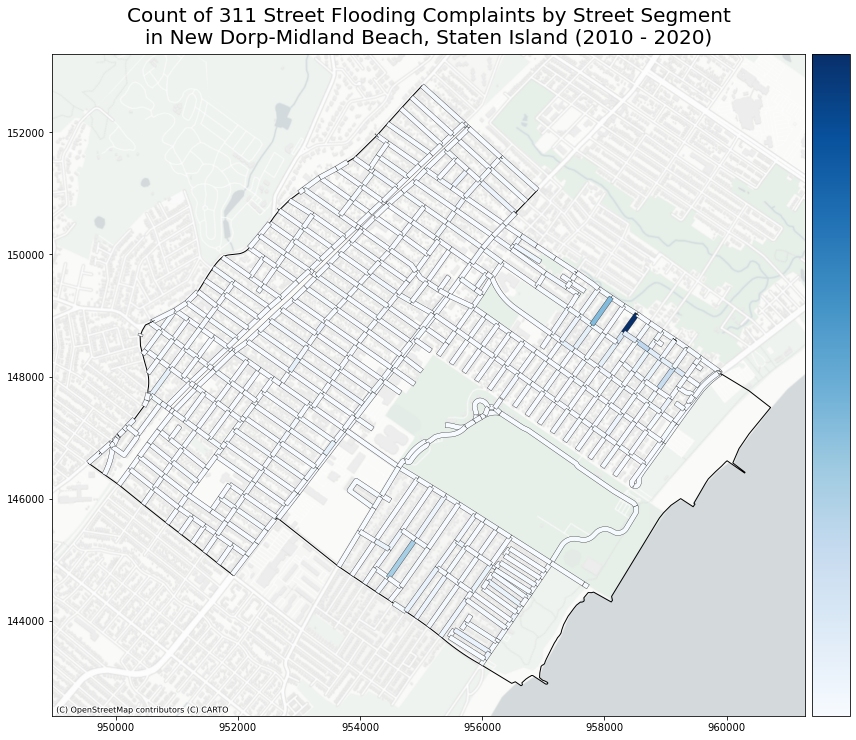

In [651]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# saving variable to format integers as strings with commas
comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))

# resizing the color bar to scale to the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        cax=cax, # legend of the color bar
                        zorder=2,                        
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True)

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of 311 Street Flooding Complaints by Street Segment\nin New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

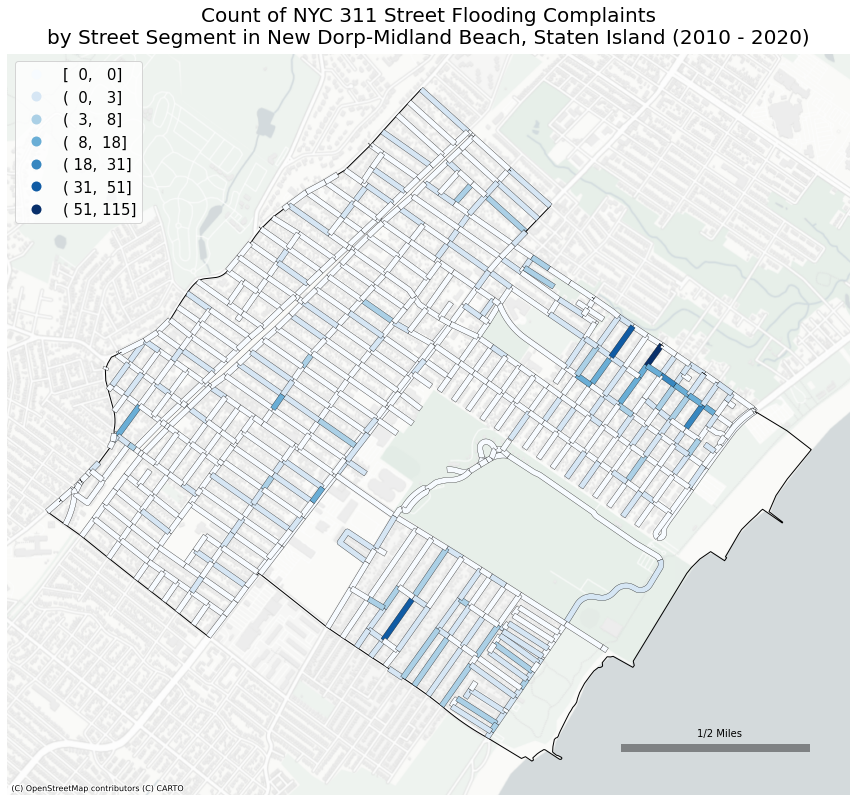

In [652]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))


ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()
# plt.savefig('figures/Arverne1.png', facecolor='w')

In [653]:
streets_with_count.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 737 entries, 0 to 736
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   physicalid    737 non-null    object  
 1   st_label      737 non-null    object  
 2   st_name       737 non-null    object  
 3   full_stree    737 non-null    object  
 4   rw_type       737 non-null    object  
 5   rw_type_name  737 non-null    object  
 6   st_width      737 non-null    object  
 7   frm_lvl_co    737 non-null    object  
 8   to_lvl_co     737 non-null    object  
 9   borocode      737 non-null    object  
 10  shape_leng    737 non-null    float64 
 11  geometry      737 non-null    geometry
 12  new_geom      737 non-null    geometry
 13  count         737 non-null    float64 
dtypes: float64(2), geometry(2), object(10)
memory usage: 86.4+ KB


In [654]:
streets_with_count['shape_leng'] = streets_with_count.geometry.length

In [655]:
streets_with_count.length.describe()

count     737.000000
mean      852.519540
std       464.511570
min       160.000006
25%       657.049620
50%       689.688260
75%      1084.789133
max      5557.842467
dtype: float64

In [656]:
streets_with_count.describe()

shape_leng       count
count   737.000000  737.000000
mean    852.519540    1.028494
std     464.511570    5.347490
min     160.000006    0.000000
25%     657.049620    0.000000
50%     689.688260    0.000000
75%    1084.789133    1.000000
max    5557.842467  115.000000

In [657]:
streets_with_count['count_per_100ft'] = (streets_with_count['count'] / streets_with_count['shape_leng']) * 100

streets_with_count.head()

physicalid        st_label   st_name       full_stree rw_type rw_type_name  \
0      63908  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   
1      98840     FREMONT AVE   FREMONT      FREMONT AVE       1       Street   
2      64022      HAMDEN AVE    HAMDEN       HAMDEN AVE       1       Street   
3     169350      SANCHEZ DR   SANCHEZ       SANCHEZ DR       1       Street   
4      63915  N RAILROAD AVE  RAILROAD  N  RAILROAD AVE       1       Street   

  st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
0       30         13        13        5   673.079794   
1       30         13        13        5  1054.133640   
2       20         13        13        5   240.551494   
3       18         13        13        5   512.291697   
4       30         13        13        5   682.338714   

                                            geometry  \
0  LINESTRING (954781.156 151271.724, 954597.833 ...   
1  LINESTRING (952841.921 150886.337, 953221.730 ...   
2  LINESTRING (957558.853 149344.789, 957591.137 ...   
3  LINESTRING (955726.813 147175.642, 955875.554 ...   
4  LINESTRING (953360.096 149917.140, 953173.390 ...   

                                            new_geom  count  count_per_100ft  
0  POLYGON ((954625.814 151063.681, 954569.851 15...    0.0              0.0  
1  POLYGON ((953242.830 150684.493, 953200.630 15...    0.0              0.0  
2  POLYGON ((957615.053 149352.770, 957567.220 14...    0.0              0.0  
3  POLYGON ((955854.127 147303.776, 955896.981 14...    0.0              0.0  
4  POLYGON ((953201.360 149705.923, 953145.420 14...    0.0              0.0

In [658]:
streets_with_count.describe()

shape_leng       count  count_per_100ft
count   737.000000  737.000000       737.000000
mean    852.519540    1.028494         0.119461
std     464.511570    5.347490         0.586599
min     160.000006    0.000000         0.000000
25%     657.049620    0.000000         0.000000
50%     689.688260    0.000000         0.000000
75%    1084.789133    1.000000         0.056918
max    5557.842467  115.000000        12.699153

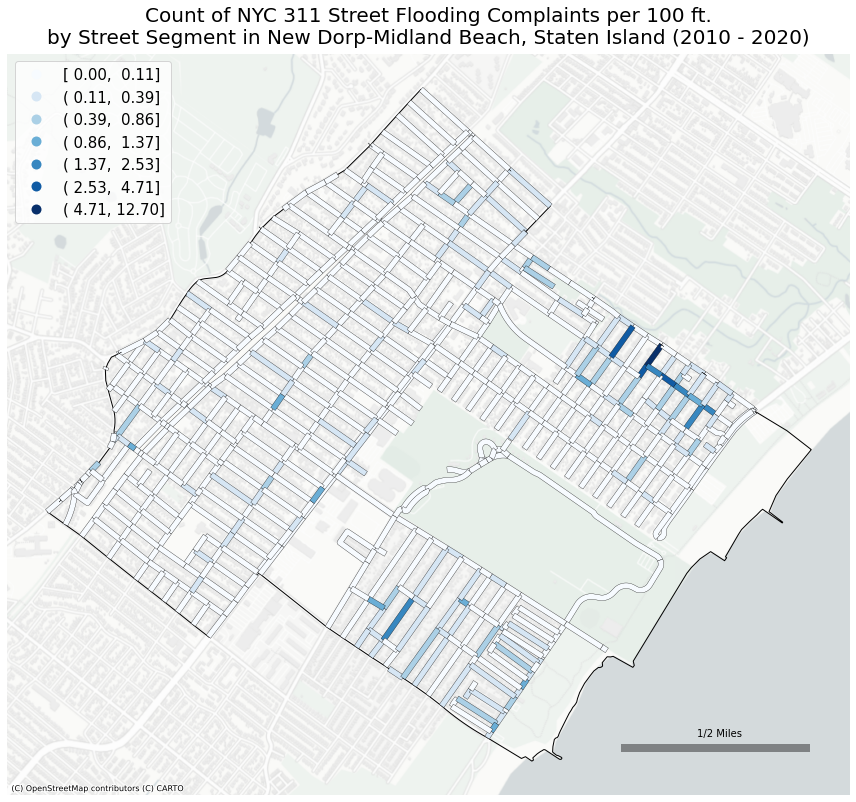

In [659]:
fig, ax = plt.subplots(figsize=(12, 12)) # creating figure

# plotting 'density (pop/sq_mi)' as a choropleth map
streets_with_count.plot(column='count_per_100ft', 
                        ax=ax, # plotting on the generated axis
                        zorder=2,
                        cmap='Blues',
                        edgecolor='black',
                        linewidth=.3,
                        legend=True, 
                        scheme='fisherjenks',
                        k=7,
                        legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "15"})

nta_shape[nta_shape.ntaname == 'New Dorp-Midland Beach'].plot(ax=ax, 
                                                              zorder=1, 
                                                              color='None', 
                                                              edgecolor='black')

# adding basemap
ctx.add_basemap(ax, 
                crs=2263, 
                source=ctx.providers.CartoDB.PositronNoLabels,
                zorder=0)

# drawing the linke coordinates on the axis
x, y = [958000, 958000+5280/2], [143000 + 130, 143000 + 130]

# plotting the line
plt.plot(x, 
         y, 
         linewidth=8,
         color='black',
         alpha=.4, zorder=3)

# adding the scale bar text to the line
plt.text(958000 + (5280/2/2.5), 143000 + 300, '1/2 Miles', dict(size=10))

ax.set_aspect('equal', 'box')

# setting title
ax.set_title('Count of NYC 311 Street Flooding Complaints per 100 ft.\nby Street Segment in New Dorp-Midland Beach, Staten Island (2010 - 2020)', 
             fontsize=20, 
             pad=10)

plt.axis('off')
plt.tight_layout()

plt.savefig('figures/pres-14.png')

<AxesSubplot:>

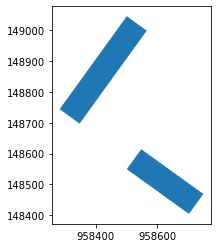

In [660]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head(2).plot()

In [661]:
streets_with_count.sort_values(by='count_per_100ft', ascending=False).head()

physicalid      st_label   st_name    full_stree rw_type rw_type_name  \
148      76941    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
473      76093  MAPLETON AVE  MAPLETON  MAPLETON AVE       1       Street   
574      52067    KISWICK ST   KISWICK    KISWICK ST       1       Street   
52       76942    GRIMSBY ST   GRIMSBY    GRIMSBY ST       1       Street   
118      85564      BADEN PL     BADEN      BADEN PL       1       Street   

    st_width frm_lvl_co to_lvl_co borocode   shape_leng  \
148       22         13        13        5   905.572235   
473       25         13        13        5   657.698955   
574       38         13        13        5  1258.589579   
52        32         13        13        5   554.966971   
118       32         13        13        5  1068.129038   

                                              geometry  \
148  LINESTRING (958533.655 149022.834, 958315.338 ...   
473  LINESTRING (958524.695 148581.558, 958726.633 ...   
574  LINESTRING (958113.203 149295.665, 957794.955 ...   
52   LINESTRING (958315.338 148720.663, 958202.776 ...   
118  LINESTRING (959135.084 148145.979, 958868.434 ...   

                                              new_geom  count  count_per_100ft  
148  POLYGON ((958347.761 148697.237, 958282.915 14...  115.0        12.699153  
473  POLYGON ((958750.008 148468.598, 958703.259 14...   31.0         4.713403  
574  POLYGON ((957827.558 148824.781, 957762.353 14...   51.0         4.052155  
52   POLYGON ((958235.642 148535.600, 958169.910 14...   18.0         3.243436  
118  POLYGON ((958900.810 147754.966, 958836.058 14...   27.0         2.527784

In [662]:
streets_with_count['count'].sum()

758.0